# **Optimizing Bank Marketing Campaigns: Predicting Term Deposit Subscriptions with High Recall**

Untuk dashboard bisa di akses melalui Looker studio [Link](https://lookerstudio.google.com/u/0/reporting/8bb67993-75b5-4417-bb0e-a285249a94b5/page/p_gf5cymg1td/edit?hl=en)

# **Define Problem**

## **Konteks**

Dataset ini berasal dari kampanye pemasaran langsung melalui panggilan telepon oleh sebuah bank di Portugal antara tahun 2008 hingga 2010, periode pemulihan pasca-krisis finansial global. Tujuannya adalah mendorong nasabah untuk berlangganan deposito berjangka, sumber pendanaan jangka panjang yang stabil. Dataset berisi **41.188 baris** data dan **21 fitur**, meliputi demografi (`age`, `job`, `education`), detail kontak (`contact`, `month`, `day_of_week`, `duration`), riwayat kampanye (`pdays`, `previous`, `poutcome`), indikator makroekonomi (`emp.var.rate`, `euribor3m`, `cons.conf.idx`), dan target (`y`: yes/no untuk langganan deposito). Sumber.

Dataset memiliki **ketidakseimbangan kelas** (~11% `y=yes`), memerlukan teknik seperti SMOTE dan metrik seperti Recall serta F2-Score untuk fokus pada nasabah potensial. Fitur **duration** harus dihapus untuk mencegah **data leakage**, karena hanya tersedia pasca-kampanye.

## **Stakeholder**
**Tim pemasaran bank**, yang merancang dan melaksanakan kampanye telemarketing, sebagai stakeholder utama. Stakeholder sekunder adalah **manajemen bank**, yang fokus pada pendapatan dan efisiensi, serta **tim data science**, yang mengembangkan model prediktif.

## **Pernyataan Masalah**
Tim pemasaran menghadapi tantangan dalam meningkatkan efektivitas kampanye telemarketing untuk deposito berjangka, dengan tingkat konversi hanya **11%** (`y=yes`). Setiap panggilan menghabiskan biaya **€0,40**, sementara langganan deposito menghasilkan **€45**. Penargetan yang tidak efisien menyebabkan pemborosan sumber daya. **False Negatives** (gagal mengidentifikasi nasabah potensial) memiliki opportunity cost **€45**, jauh lebih besar dari **False Positives** (€0,40). Evaluasi manual data kompleks (demografi, riwayat kontak, makroekonomi) tidak akurat, menghasilkan ROI rendah dan menghambat daya saing bank pasca-krisis.

## **Mengapa Masalah Ini Penting**
- **Dampak Finansial**: Kenaikan konversi **1%** dapat menghasilkan **€1,8 juta per tahun** (41.188 kontak, €45 per langganan). Pengurangan panggilan 20% menghemat **€32.950**.
- **Pentingnya Strategis**: Kampanye efisien meningkatkan akuisisi nasabah, memperkuat stabilitas keuangan, dan memperbaiki posisi pasar di tengah persaingan pasca-2008.
- **Pengalaman Nasabah**: Penargetan tepat meningkatkan kepuasan dan loyalitas nasabah.

## **Tujuan dan Sasaran**

1. **Mengidentifikasi Faktor Kunci Keberhasilan Kampanye**:
    - Menemukan minimal tiga **fitur utama** melalui feature importance dan EDA.
    - Memberikan wawasan tentang metode kontak, waktu, dan segmen nasabah prioritas.
2. **Membangun Model Prediktif untuk Penargetan Real-Time**:
    - Membangun model dan memprioritaskan Recall karena ketidakseimbangan kelas.
3. **Memvalidasi Wawasan dengan Riset Eksternal**:
    - Menganalisis tren makroekonomi untuk mengontekstualisasikan temuan.
    - Membandingkan dengan praktik terbaik telemarketing untuk rekomendasi yang lebih kuat.


# Data Understanding

Memahami struktur, isi, dan karakteristik dataset **bank-additional-full.csv** untuk mendukung tujuan proyek, yaitu meningkatkan tingkat konversi kampanye pemasaran deposito berjangka dari 11% ke 20%, mengurangi biaya kampanye 30%, dan meminimalkan False Negatives (€45 per nasabah terlewat) melalui penargetan 50% nasabah berprobabilitas tinggi. Pemahaman ini menghubungkan fitur data dengan masalah bisnis (konversi rendah, ROI rendah) dan menentukan langkah preprocessing serta analisis lanjutan untuk mencapai metrik Recall ≥85% dan F2-Score ≥80%.

## Library

In [50]:
import os
import warnings
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

# Statistik
from scipy.stats import (
    uniform, randint, shapiro, kstest, anderson, chi2_contingency, normaltest
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualisasi
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

# Train-test split & Model Selection
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold, cross_val_score, cross_validate,
    GridSearchCV, RandomizedSearchCV
)

# Feature Selection
from sklearn.feature_selection import SelectPercentile, SelectFromModel

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Model Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, make_scorer, precision_recall_curve
)

# Konfigurasi
warnings.filterwarnings("ignore")
os.environ['LIGHTGBM_VERBOSITY'] = '-1'

## Load Dataset

In [52]:
df = pd.read_csv("../Data/bank-additional-full.csv", encoding='utf-8', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Feature Explenation

### **Column Target**

| Kolom | Penjelasan |
| ----- | ----- |
| `y`   | **Target/output** → apakah klien berlangganan deposito berjangka (binary: `yes` atau `no`). Fokus klasifikasi model nantinya ada di sini. |

### **Data Sosial-Ekonomi Nasabah**

| Kolom       | Penjelasan  |
| ----------- | ----------- |
| `age`       | Usia klien (numerik). Bisa dipakai buat segmentasi umur atau cluster usia tertentu. |
| `job`       | Jenis pekerjaan klien, seperti admin., technician, entrepreneur, dll. Ini **kategori sosial ekonomi** yang bisa memengaruhi keputusan finansial. |
| `marital`   | Status pernikahan (`married`, `single`, `divorced`). Terkait stabilitas dan kebiasaan keuangan. |
| `education` | Tingkat pendidikan: `basic`, `high.school`, `university`, `professional.course`, dll. |
| `default`   | Apakah klien punya kredit macet sebelumnya (`yes`/`no`). Bisa indikasi risiko. |
| `housing`   | Apakah klien memiliki kredit rumah (`yes`/`no`). |
| `loan`      | Apakah klien punya pinjaman pribadi (`yes`/`no`). |

### **Informasi Kontak dan Kampanye**

| Kolom         | Penjelasan  |
| ----------    | ----------  |
| `contact`     | Jenis komunikasi yang digunakan saat kampanye: `cellular`, `telephone`.           |
| `month`       | Bulan terakhir klien dihubungi (dalam kampanye terakhir): `jan`, `feb`, … `dec`.  |
| `day_of_week` | Hari dalam seminggu saat kontak dilakukan (`mon`–`fri`). Bisa lihat tren waktu.   |
| `duration`    | Lama durasi kontak terakhir dalam detik. |

### **Informasi Kampanye**

| Kolom      | Penjelasan |
| ---------- | ---------- |
| `campaign` | Jumlah kontak selama kampanye marketing terakhir (numerik). |
| `pdays`    | Jumlah hari sejak klien terakhir kali dihubungi oleh kampanye sebelumnya. Jika belum pernah, nilainya `999`. |
| `previous` | Berapa kali klien telah dihubungi dalam kampanye sebelumnya. |
| `poutcome` | Hasil dari kampanye marketing sebelumnya: `success`, `failure`, `nonexistent`. |

### **Indikator Ekonomi Makro (saat kampanye)**

| Kolom            | Penjelasan                                                            |
| ---------------- | --------------------------------------------------------------------- |
| `emp.var.rate`   | Tingkat variasi lapangan kerja (indikator ekonomi, biasanya bulanan). |
| `cons.price.idx` | Indeks harga konsumen (inflasi).                                      |
| `cons.conf.idx`  | Indeks kepercayaan konsumen.                                          |
| `euribor3m`      | Suku bunga EURIBOR 3 bulan (referensi suku bunga pasar Eropa).        |
| `nr.employed`    | Jumlah karyawan rata-rata (indikator ekonomi umum).                   |

### **Ringkasan**

* **Variabel target:** `y`
* **Fitur personal:** `age`, `job`, `marital`, `education`, `default`, `housing`, `loan`
* **Fitur kampanye marketing:** `contact`, `month`, `day_of_week`, `duration`, `campaign`, `pdays`, `previous`, `poutcome`
* **Fitur ekonomi makro:** `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, `nr.employed`


## Missing Value

In [55]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

**Tidak ada Missing Value**

## Duplicated Data

In [56]:
df.duplicated().sum()

np.int64(12)

**Terdapat 12 Duplicated data**

## Target Class Distribution

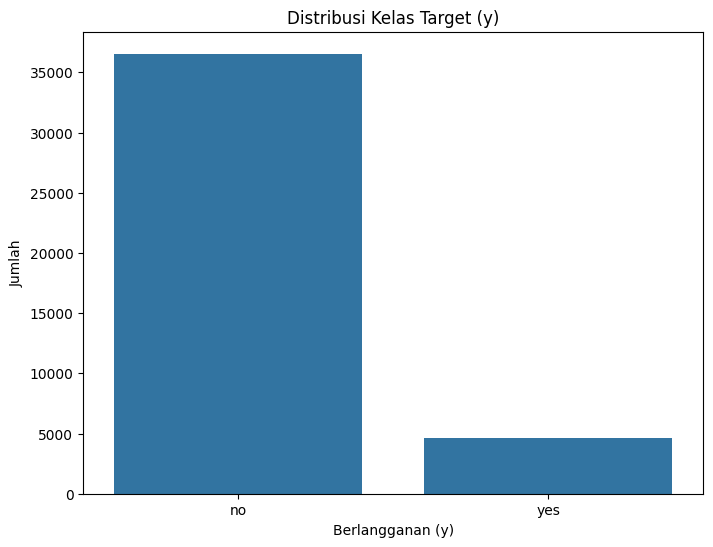


Proporsi Kelas Target:
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


In [57]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='y')
plt.title('Distribusi Kelas Target (y)')
plt.xlabel('Berlangganan (y)')
plt.ylabel('Jumlah')
plt.show()
print("\nProporsi Kelas Target:")
print(df['y'].value_counts(normalize=True))

Kelas target `y` sangat tidak seimbang (~11.3% `yes`, ~88.7% `no`), memerlukan teknik seperti SMOTE dan metrik Recall untuk evaluasi model.

## Unknown Check

In [58]:
df.isin(['unknown']).sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [59]:
print("\nProporsi Nilai 'unknown':")
for col in ['job', 'education', 'default', 'housing', 'loan', 'poutcome']:
    unknown_prop = df[col].value_counts(normalize=True).get('unknown', 0)
    print(f"{col}: {unknown_prop:.4f}")


Proporsi Nilai 'unknown':
job: 0.0080
education: 0.0420
default: 0.2087
housing: 0.0240
loan: 0.0240
poutcome: 0.0000


Nilai "unknown" signifikan di `poutcome` (~86%) dan `default` (~21%), menunjukkan perlunya imputasi atau penghapusan di tahap preprocessing.

## Analisis Deskriptif

In [60]:
print("\nStatistik Deskriptif Numerik:")
print(df.describe())
print("\nDistribusi Fitur Kategorikal:")
for col in df.select_dtypes(include='object').columns:
    print(f"\n{col}:\n", df[col].value_counts(normalize=True))


Statistik Deskriptif Numerik:
               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960    

## Numeric Data

In [61]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Count Numeric Column

In [62]:
len(df.select_dtypes(include = 'number').columns)

10

### Normality Test

In [63]:
def check_normality(df):
    def test_normality(df):
        shapiro_p = shapiro(df).pvalue
        ks_p = kstest(df, 'norm').pvalue
        anderson_result = anderson(df)
        ad_result = anderson_result.statistic < anderson_result.critical_values[2] #using 5% critical value

        return {
            'Shapiro-Wilk': 'Normal' if shapiro_p > 0.05 else 'Not-normal',
            'Kolmogorov-Smirnov': 'Normal' if ks_p > 0.05 else 'Not-normal',
            'Anderson-Darling': 'Normal' if ad_result else 'Not-normal'
        }

    numeric_cols = df.select_dtypes(include=["number"]).columns
    results = {col: test_normality(df[col]) for col in numeric_cols}
    return pd.DataFrame.from_dict(results, orient='index').rename_axis('Feature')

normality_results = check_normality(df)
normality_results

,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling
Feature,,,
age,Not-normal,Not-normal,Not-normal
duration,Not-normal,Not-normal,Not-normal
campaign,Not-normal,Not-normal,Not-normal
pdays,Not-normal,Not-normal,Not-normal
previous,Not-normal,Not-normal,Not-normal
emp.var.rate,Not-normal,Not-normal,Not-normal
cons.price.idx,Not-normal,Not-normal,Not-normal
cons.conf.idx,Not-normal,Not-normal,Not-normal
euribor3m,Not-normal,Not-normal,Not-normal


Diketahui bahwa seluruh variabel numerik tidak berdistribusi normal.

#### Data Distribution

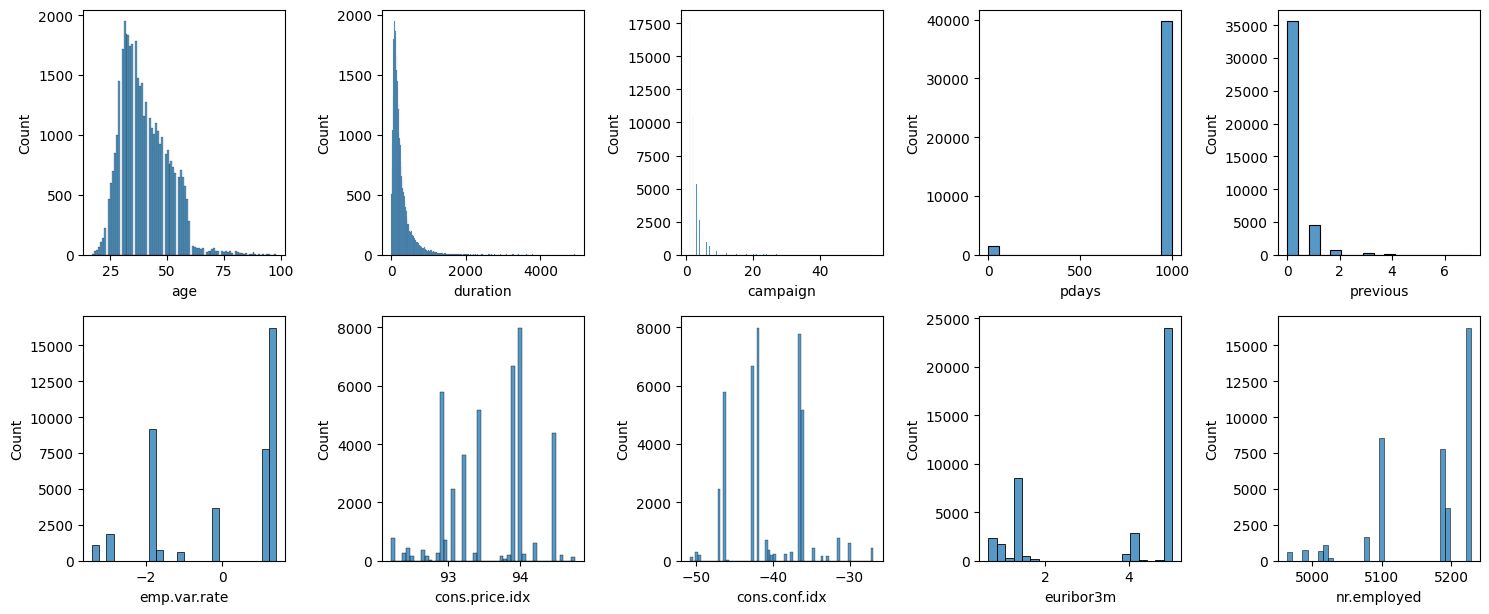

In [64]:
numeric = df.select_dtypes(include = 'number')

# change the size of the frame (the graph container)
plt.figure(figsize = (15,15))

position = 1 # initialize the position starting from 1
for each_column in numeric.columns: # numeric.columns = the names of the columns in the list
  plt.subplot(5,5,position)
  sns.histplot(df[each_column])
  position = position + 1
  # so that they don't overlap
  plt.tight_layout()

Dilihat dari persebarannya grafiknya, didapatkan bahwa data memiliki distribusi tidak normal

### Outliers

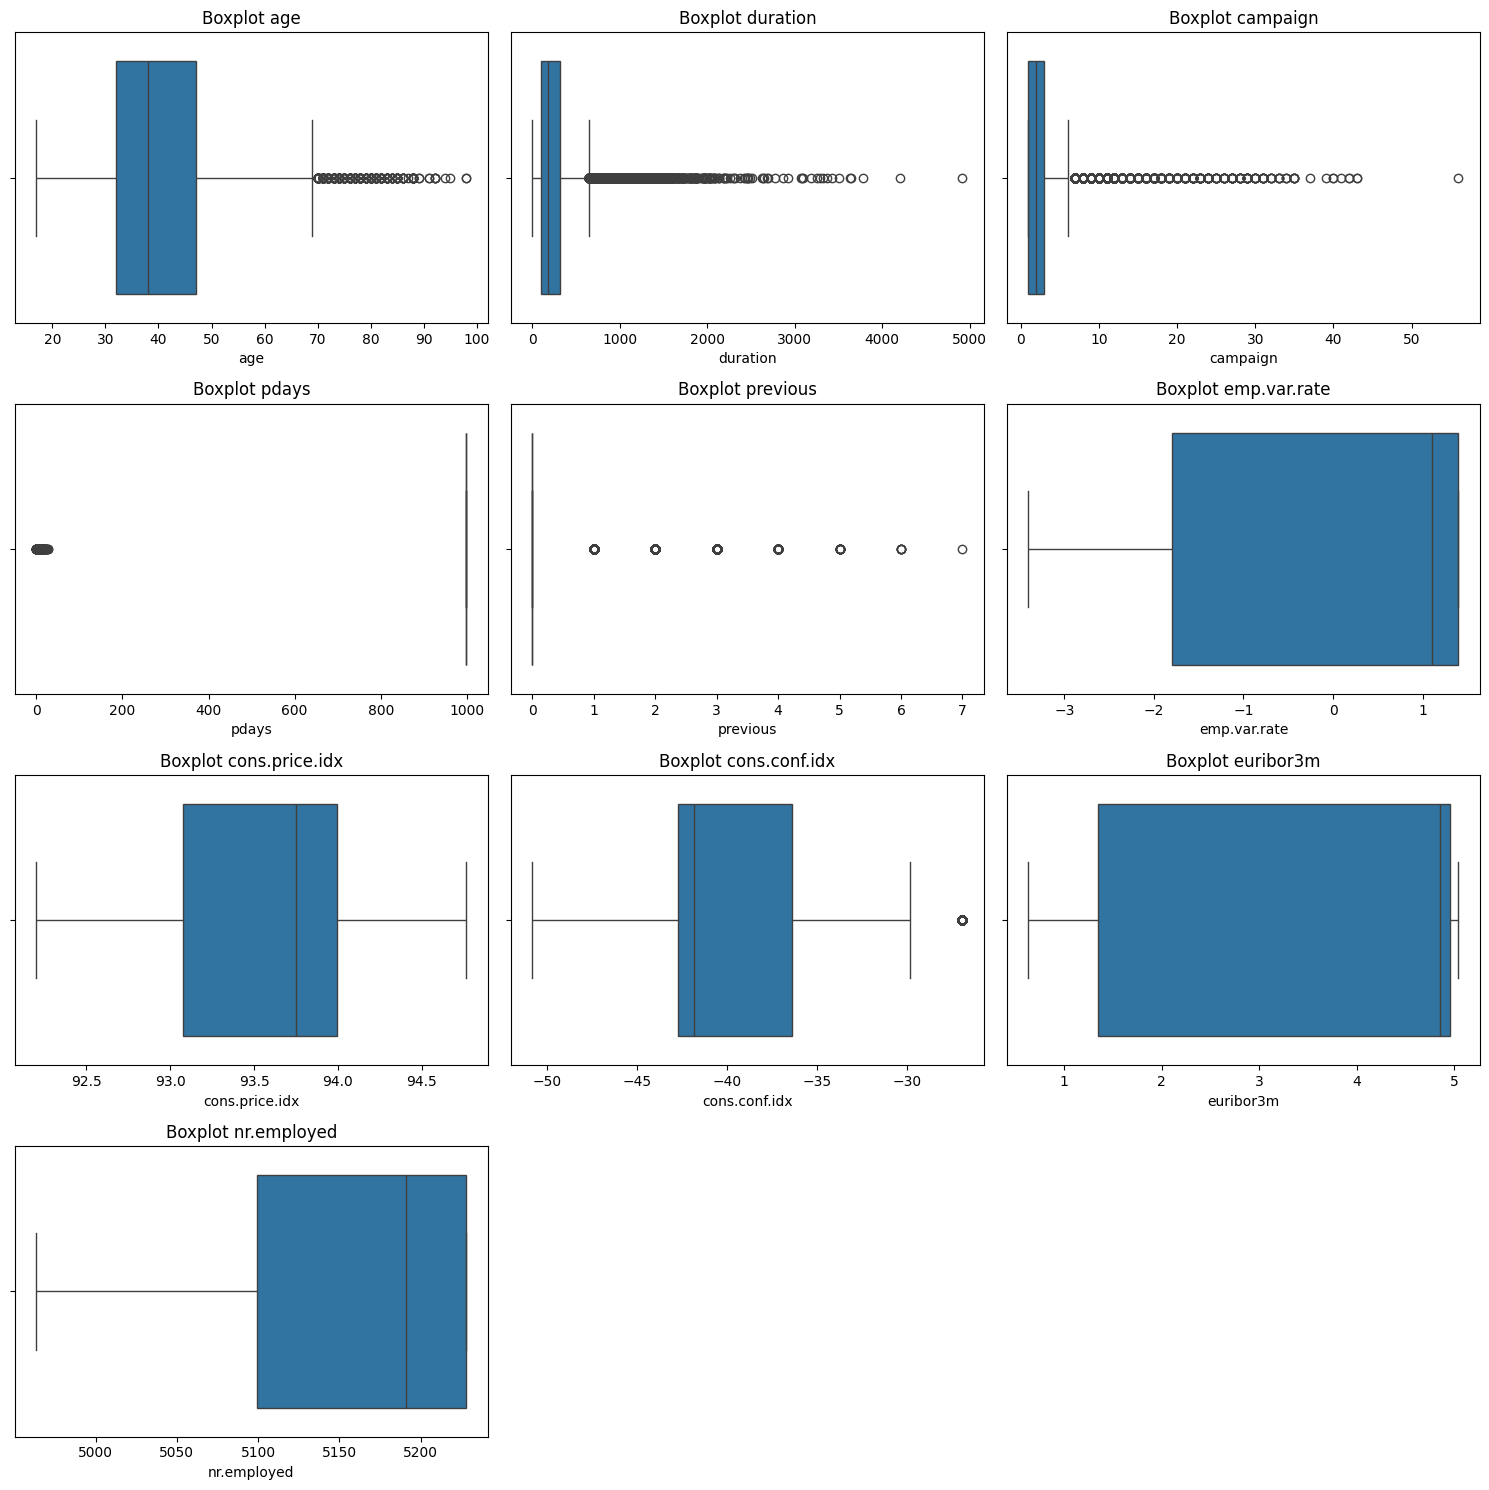

In [65]:
numeric_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                'euribor3m', 'nr.employed']
plt.figure(figsize=(15, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')
    plt.tight_layout()
plt.show()

Dapat dilihat dari scatter plot diatas pada fitur **age**, **duration**, **campaign**, **pdays**, **previous**, dan **cons.conf.idx** terdapat outliers

In [66]:
# Pilih kolom numerik
numeric_columns = df.select_dtypes(include='number')
list_outliers_count = []

for column in numeric_columns.columns:
    q3 = numeric_columns.describe().loc['75%', column]
    q1 = numeric_columns.describe().loc['25%', column]
    iqr = q3 - q1
    whisker = 1.5 * iqr
    upper_bound = q3 + whisker
    lower_bound = q1 - whisker

    # Perhitungan outliers
    outliers_count = len(df[(df[column] > upper_bound) | (df[column] < lower_bound)])
    list_outliers_count.append(outliers_count)

outliers_df = pd.DataFrame({
    'Column': numeric_columns.columns,
    'Outliers Count': list_outliers_count
})

# Sort by 'Outliers Count' in descending order
outliers_df_sorted = outliers_df.sort_values(by='Outliers Count', ascending=False)
outliers_df_sorted

,Column,Outliers Count
4,previous,5625
1,duration,2963
2,campaign,2406
3,pdays,1515
0,age,469
7,cons.conf.idx,447
5,emp.var.rate,0
6,cons.price.idx,0
8,euribor3m,0
9,nr.employed,0


#### Cek Outliers `campaign`

`campaign` merupakan jumlah kontak yang dilakukan selama kampanye ini dan untuk klien ini (numerik, termasuk kontak terakhir)

In [67]:
df[df['campaign'] >= 7]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
887,54,admin.,married,university.degree,no,no,no,telephone,may,wed,388,7,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
1043,41,technician,single,university.degree,unknown,no,no,telephone,may,wed,79,8,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
1094,40,technician,married,professional.course,no,yes,no,telephone,may,wed,253,8,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
1097,51,blue-collar,married,basic.4y,unknown,yes,no,telephone,may,wed,244,7,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
1230,48,blue-collar,divorced,basic.4y,no,no,no,telephone,may,thu,521,7,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40611,75,retired,married,basic.9y,no,no,no,telephone,sep,fri,543,9,999,1,failure,-1.1,94.199,-37.5,0.883,4963.6,no
40631,88,retired,married,basic.4y,no,yes,no,cellular,sep,mon,213,7,999,0,nonexistent,-1.1,94.199,-37.5,0.882,4963.6,no
40698,29,technician,single,professional.course,no,yes,no,cellular,sep,mon,157,7,3,5,success,-1.1,94.199,-37.5,0.879,4963.6,no
40821,33,technician,single,professional.course,no,yes,no,cellular,sep,fri,246,9,999,2,failure,-1.1,94.199,-37.5,0.879,4963.6,no


Outliers pada campaign tidak memberikan banyak pengaruh, maka dipertahankan dahulu

#### Cek Outliers `pdays`

`pdays` merupakan jumlah hari yang telah berlalu sejak klien terakhir dihubungi dari kampanye sebelumnya. Terdapat data angka 999 berarti klien belum pernah dihubungi sebelumnya

In [68]:
df[df['pdays'] != 999]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
24108,37,admin.,married,university.degree,no,yes,no,telephone,nov,wed,119,1,6,1,success,-0.1,93.200,-42.0,4.286,5195.8,no
24264,48,management,married,university.degree,no,yes,no,cellular,nov,mon,112,1,4,1,success,-0.1,93.200,-42.0,4.191,5195.8,no
24279,42,technician,married,professional.course,unknown,yes,no,cellular,nov,mon,94,1,4,1,success,-0.1,93.200,-42.0,4.191,5195.8,no
24397,50,entrepreneur,married,university.degree,unknown,yes,no,cellular,nov,mon,77,1,3,1,success,-0.1,93.200,-42.0,4.191,5195.8,no
24482,36,self-employed,single,university.degree,no,yes,no,cellular,nov,mon,200,2,4,1,success,-0.1,93.200,-42.0,4.191,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41163,35,technician,divorced,basic.4y,no,yes,no,cellular,nov,tue,385,3,4,2,success,-1.1,94.767,-50.8,1.035,4963.6,yes
41164,54,admin.,married,professional.course,no,no,no,cellular,nov,tue,1868,2,10,1,success,-1.1,94.767,-50.8,1.035,4963.6,yes
41174,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,208,1,1,6,success,-1.1,94.767,-50.8,1.031,4963.6,yes
41178,62,retired,married,university.degree,no,no,no,cellular,nov,thu,483,2,6,3,success,-1.1,94.767,-50.8,1.031,4963.6,yes


In [69]:
len(df[df['pdays'] != 999]) / len(df) * 100

3.6782558026609693

Outliers pada pdays tidak memberikan banyak pengaruh, maka dipertahankan dahulu

#### Cek Outliers `previous`

Terdapat data previous adalah > 0 dan pdays == 999, diputuskan Menyelamatkan data ini dengan menggantinya dengan pertimbangan data pdays selain 999 (pernah dihubungi) dan poutcome.

In [70]:
df[df['previous'] != 0]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
24013,38,blue-collar,single,unknown,no,yes,no,telephone,oct,tue,39,1,999,1,failure,-0.1,93.798,-40.4,4.968,5195.8,no
24019,40,services,married,high.school,no,yes,no,telephone,oct,tue,144,1,999,1,failure,-0.1,93.798,-40.4,4.968,5195.8,yes
24076,36,admin.,married,university.degree,no,yes,no,telephone,nov,wed,449,1,999,1,failure,-0.1,93.200,-42.0,4.663,5195.8,no
24102,36,admin.,married,high.school,no,yes,no,telephone,nov,wed,114,1,999,1,failure,-0.1,93.200,-42.0,4.286,5195.8,yes
24108,37,admin.,married,university.degree,no,yes,no,telephone,nov,wed,119,1,6,1,success,-0.1,93.200,-42.0,4.286,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41174,62,retired,married,university.degree,no,yes,no,cellular,nov,thu,208,1,1,6,success,-1.1,94.767,-50.8,1.031,4963.6,yes
41175,34,student,single,unknown,no,yes,no,cellular,nov,thu,180,1,999,2,failure,-1.1,94.767,-50.8,1.031,4963.6,no
41178,62,retired,married,university.degree,no,no,no,cellular,nov,thu,483,2,6,3,success,-1.1,94.767,-50.8,1.031,4963.6,yes
41182,29,unemployed,single,basic.4y,no,yes,no,cellular,nov,fri,112,1,9,1,success,-1.1,94.767,-50.8,1.028,4963.6,no


## Visualisasi Distribusi untuk Semua Fitur Numerik

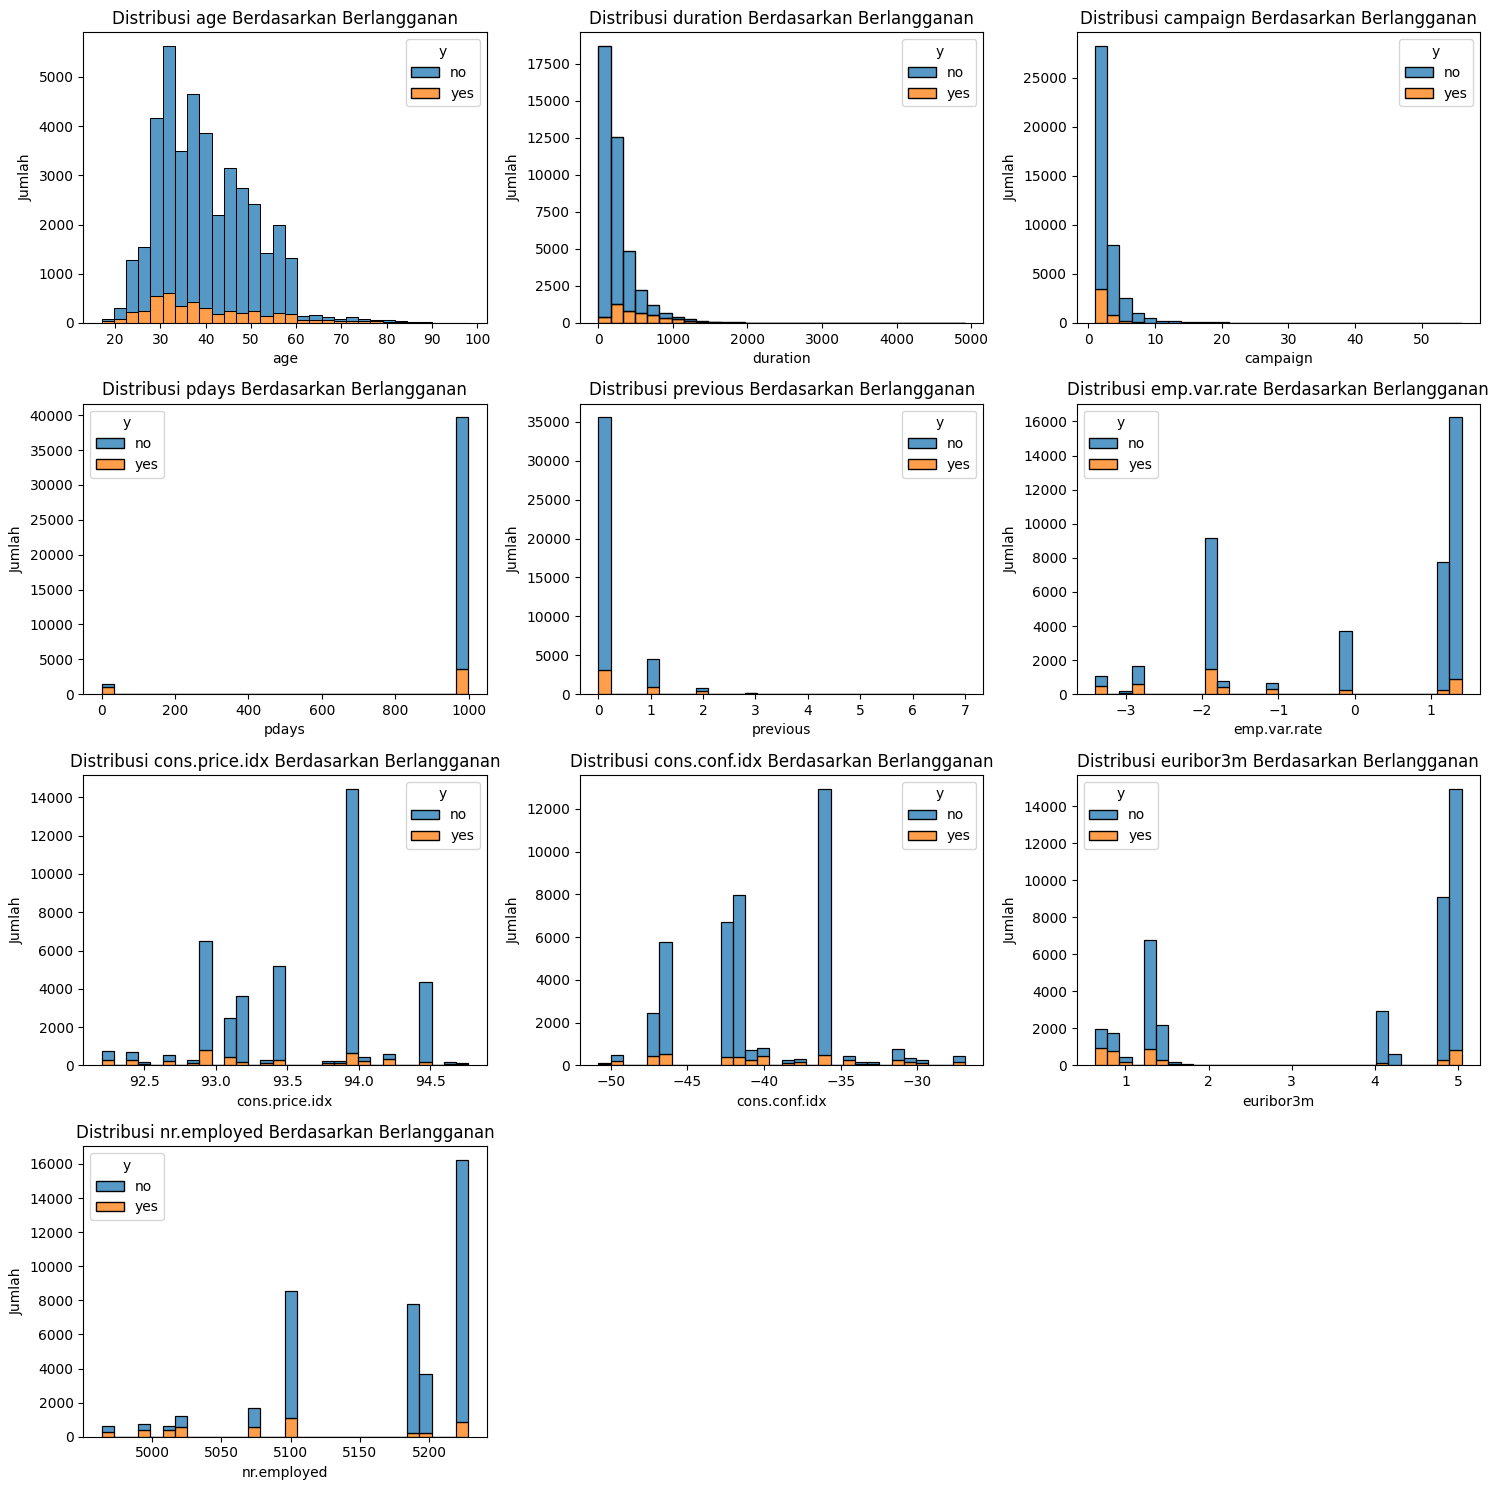

In [71]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data=df, x=col, hue='y', multiple='stack', bins=30)
    plt.title(f'Distribusi {col} Berdasarkan Berlangganan')
    plt.xlabel(col)
    plt.ylabel('Jumlah')
    plt.tight_layout()
plt.show()

## Correlation Metrics

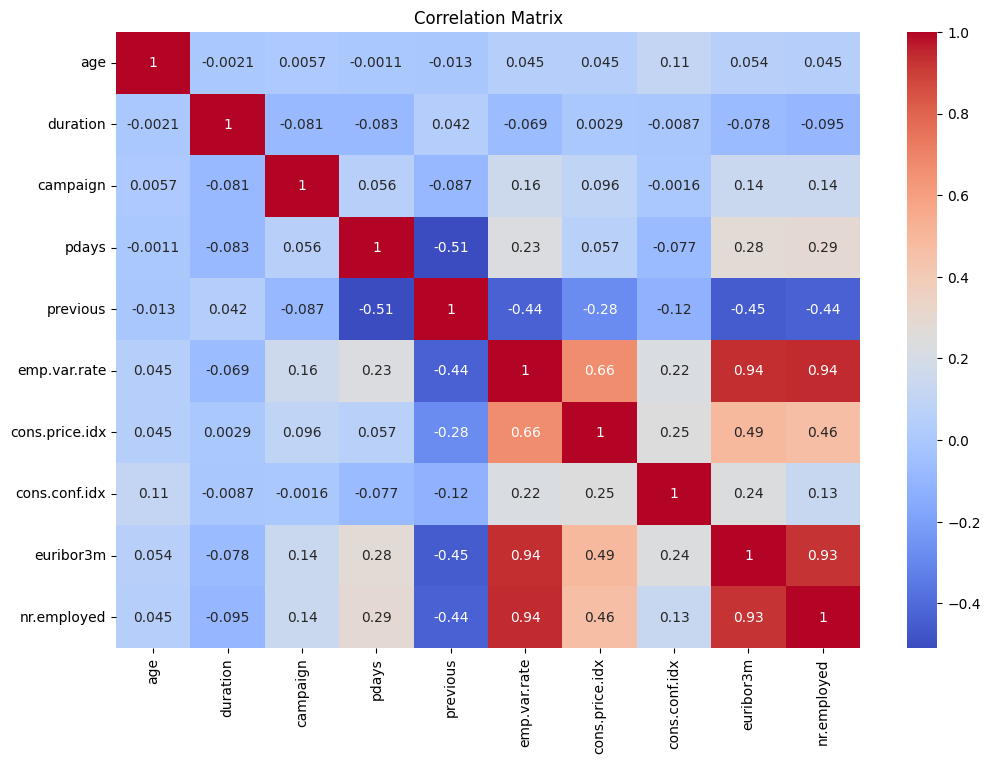

In [72]:
plt.figure(figsize=(12, 8))
sns.heatmap(numeric.corr(method='spearman'), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Korelasi yang sangat tinggi (>0.7) terdapat pada :

- `nr.employed` dengan `euribor3m`
- `nr.employed` dengan `emp.var.rate`
- `emp.var.rate` dengan `euribor3m`

Korelasi tinggi (0.5 - 0.7) terdapat pada :

- `cons.price.idx` dengan `emp.var.rate`

## Multikolinearitas

Variance Inflation Factor (VIF) adalah metode umum yang digunakan untuk mendeteksi adanya multikolinearitas antara variabel independen dalam sebuah model regresi. VIF mengukur seberapa besar varians dari estimasi koefisien sebuah variabel meningkat karena adanya korelasi linear dengan variabel lain.

Secara umum, nilai VIF lebih besar dari 10 dianggap menunjukkan adanya multikolinearitas yang serius. Tetapi, ada beberapa sumber yang menggunakan ambang batas 5 sebagai indikator awal multikolinearitas.

In [73]:
# Memilih hanya kolom numerik
num_cols = df.select_dtypes(include=['number'])

# Menghitung VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = num_cols.columns
vif_data["VIF"] = [variance_inflation_factor(num_cols.values, i) for i in range(len(num_cols.columns))]
vif_data.sort_values(by='VIF', ascending=False)

,Feature,VIF
9,nr.employed,26746.634212
6,cons.price.idx,22561.123124
8,euribor3m,226.237349
7,cons.conf.idx,120.086975
3,pdays,44.413175
5,emp.var.rate,28.910219
0,age,16.047296
1,duration,2.011044
4,previous,2.001464
2,campaign,1.921499


Fitur dengan multikolinearitas rendah :

- `campaign`
- `duration`
- `previous`

Mayoritas variabel yang berkaitan dengan sosial ekonomi memiliki multikolinearitas yang tinggi :

- `nr.employed`
- `cons.price.idx`
- `euribor3m`
- `cons.conf.idx`
- `pdays`
- `emp.var.rate`
- `age`

## Categorical Variables

In [74]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [75]:
categoric = df.select_dtypes(include = 'object')
categoric.nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
y               2
dtype: int64

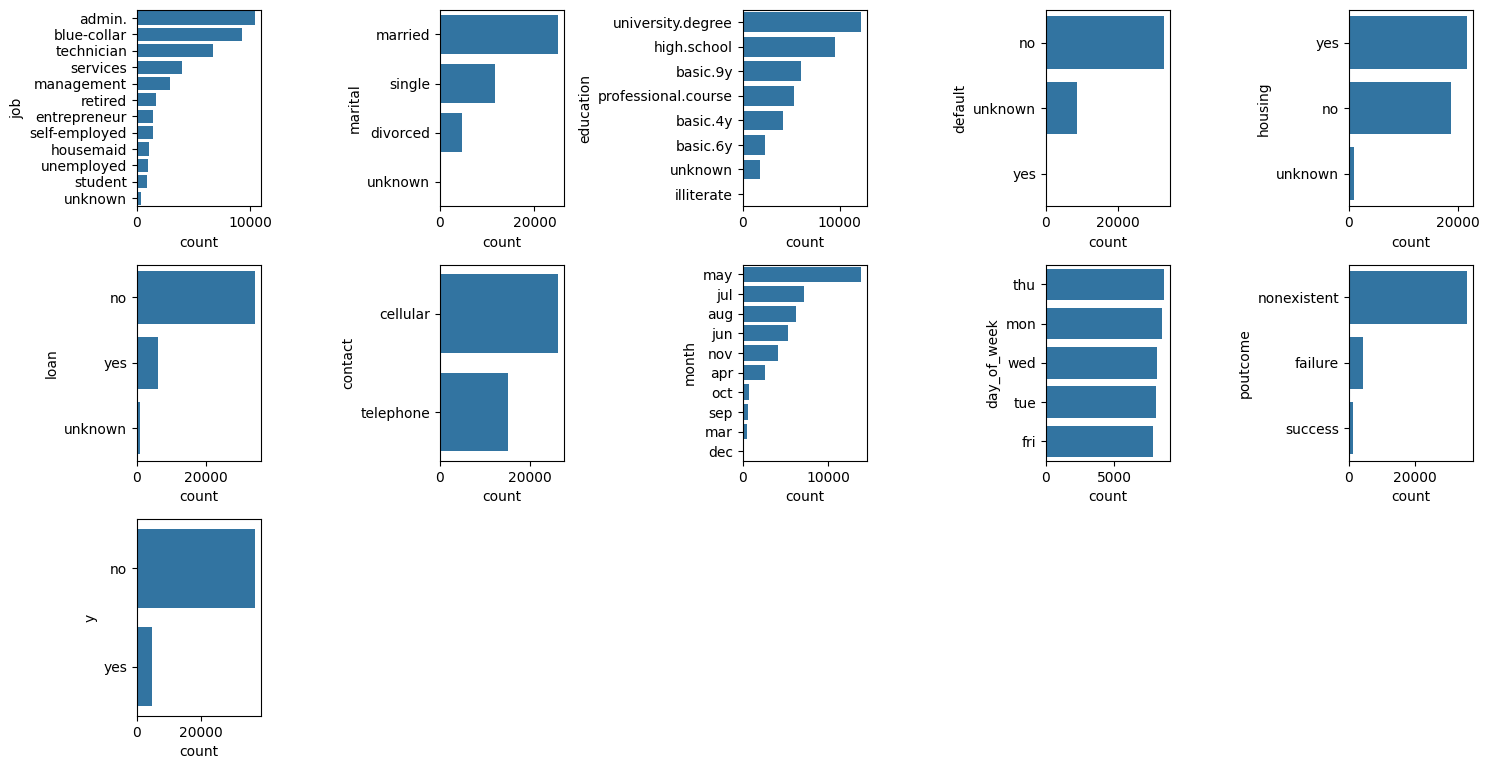

In [77]:
# Change the figure size (container for the plots)
plt.figure(figsize=(15, 15))  # (width, height)

position = 1  # Initialize position starting from 1
for each_column in categoric.columns:  # categorical.columns = list of column names
    plt.subplot(6, 5, position)
    sns.barplot(df[each_column].value_counts().head(15), orient='h')
    position = position + 1
    # Prevent overlapping
    plt.tight_layout()

### Visualisasi Fitur Kunci untuk Semua Fitur Kategorikal

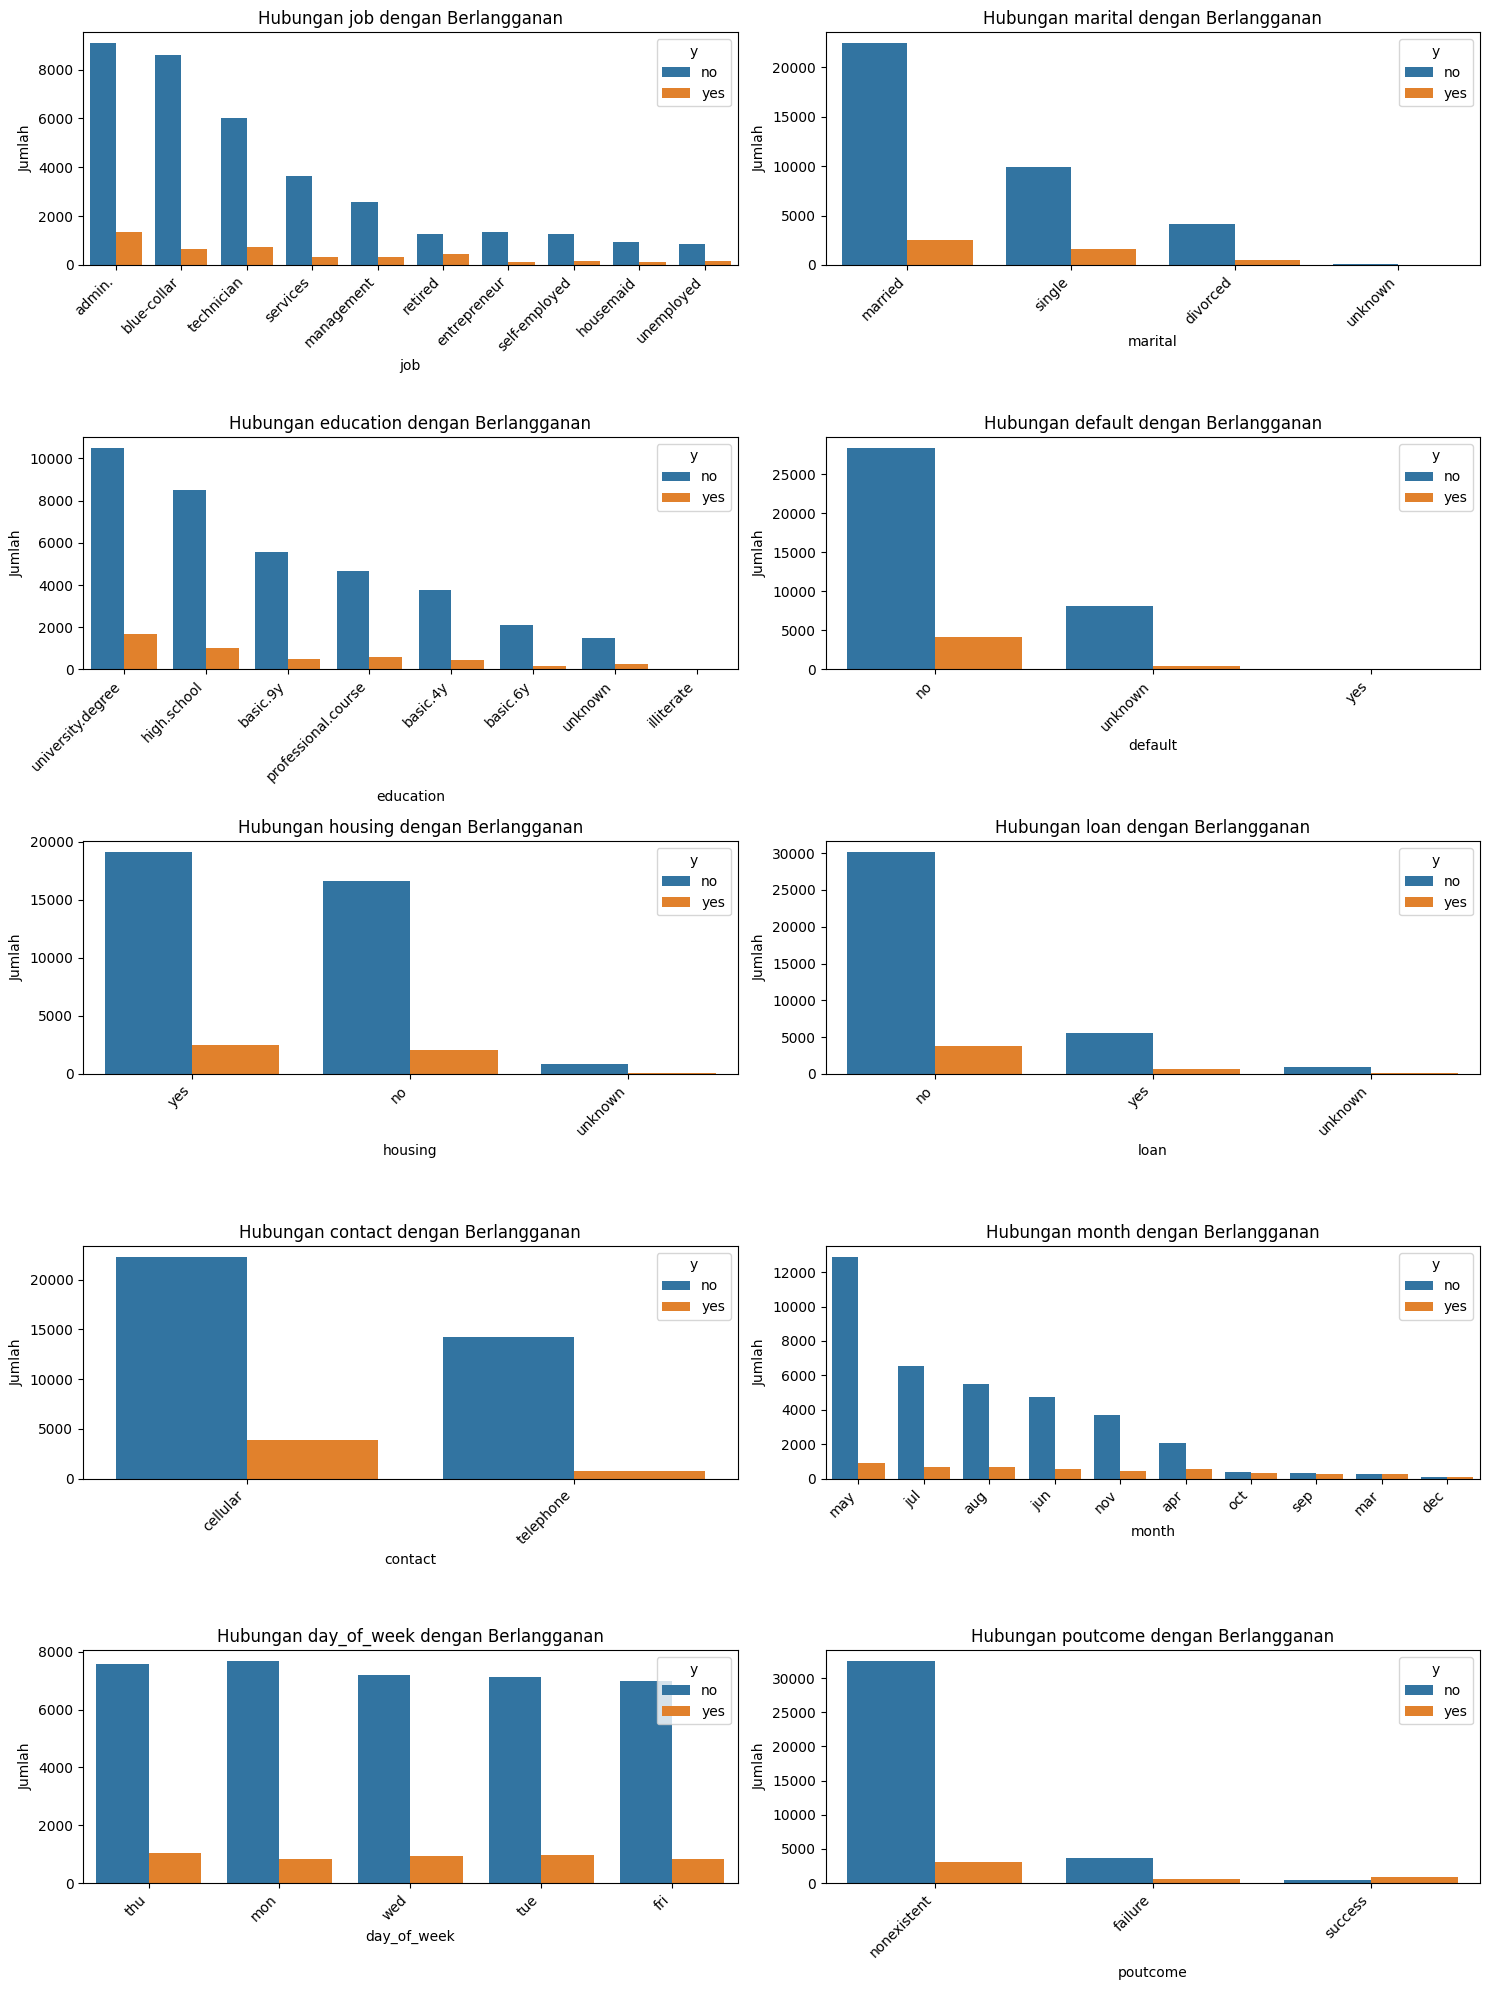

In [78]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                    'loan', 'contact', 'month', 'day_of_week', 'poutcome']
plt.figure(figsize=(15, 20))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(5, 2, i)
    sns.countplot(data=df, x=col, hue='y', order=df[col].value_counts().index[:10])
    plt.title(f'Hubungan {col} dengan Berlangganan')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(col)
    plt.ylabel('Jumlah')
    plt.tight_layout()
plt.show()

## Kesimpulan

### Struktur Dataset
- **Sumber**: [Kaggle](https://www.kaggle.com/datasets/volodymyrgavrysh/bank-marketing-campaigns-dataset).
- **Ukuran**: 41.188 baris, 21 kolom.
- **Fitur**:
  - **Demografi**:
    - `age`: Usia nasabah (numerik, rentang: 17–98 tahun), relevan untuk segmentasi nasabah.
    - `job`: Pekerjaan (kategorikal, 12 kategori: admin, blue-collar, technician, dll.), mendukung penargetan segmen spesifik.
    - `marital`: Status pernikahan (kategorikal: married, single, divorced, unknown), untuk profil nasabah.
    - `education`: Tingkat pendidikan (kategorikal: basic.4y, high.school, university.degree, dll., termasuk unknown), untuk segmentasi.
    - `default`: Status kredit macet (kategorikal: yes, no, unknown), indikator risiko keuangan.
    - `housing`: Pinjaman perumahan (kategorikal: yes, no, unknown), untuk profil finansial.
    - `loan`: Pinjaman pribadi (kategorikal: yes, no, unknown), untuk profil finansial.
  - **Kontak Kampanye**:
    - `contact`: Jenis kontak (kategorikal: cellular, telephone), relevan untuk optimasi metode kontak.
    - `month`: Bulan kontak terakhir (kategorikal: jan, feb, ..., dec), untuk optimasi waktu kampanye.
    - `day_of_week`: Hari kontak (kategorikal: mon, tue, ..., fri), untuk optimasi waktu.
    - `duration`: Durasi panggilan dalam detik (numerik, rentang: 0–4918 detik), dihapus karena data leakage.
    - `campaign`: Jumlah kontak selama kampanye ini (numerik, rentang: 1–56), untuk efisiensi kontak.
  - **Riwayat Kampanye**:
    - `pdays`: Hari sejak kontak terakhir dari kampanye sebelumnya (numerik, 999 berarti belum dikontak), untuk riwayat interaksi.
    - `previous`: Jumlah kontak sebelum kampanye ini (numerik, rentang: 0–7), untuk riwayat interaksi.
    - `poutcome`: Hasil kampanye sebelumnya (kategorikal: success, failure, nonexistent), kunci untuk prediksi konversi.
  - **Makroekonomi**:
    - `emp.var.rate`: Tingkat variasi pekerjaan (numerik, rentang: -3.4 hingga 1.4), untuk konteks ekonomi.
    - `cons.price.idx`: Indeks harga konsumen (numerik, rentang: 92.893–94.767), untuk konteks ekonomi.
    - `cons.conf.idx`: Indeks kepercayaan konsumen (numerik, rentang: -50.8 hingga -26.9), untuk konteks ekonomi.
    - `euribor3m`: Suku bunga Euribor 3 bulan (numerik, rentang: 0.634–5.045), untuk konteks ekonomi.
    - `nr.employed`: Jumlah karyawan (numerik, rentang: 4963.6–5228.1), untuk konteks ekonomi.
  - **Target**:
    - `y`: Langganan deposito (kategorikal: yes, no), untuk prediksi konversi.
- **Tipe Data** (berdasarkan `df.info()`):
  - Numerik (`int64`/`float64`): `age`, `duration`, `campaign`, `pdays`, `previous`, `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, `nr.employed`.
  - Kategorikal (`object`): `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `month`, `day_of_week`, `poutcome`, `y`.

### Relevansi
- **Konversi Rendah (11%)**: Fitur seperti `poutcome` (success berkorelasi dengan `y=yes`) dan demografi (`job`, `age`) mendukung identifikasi nasabah potensial untuk meningkatkan konversi ke 20% dan meminimalkan False Negatives (€45 per nasabah terlewat).
- **Efisiensi Kampanye**: Fitur `contact` (cellular vs. telephone) dan `month` mendukung optimasi metode dan waktu kontak untuk mengurangi biaya kampanye 30%.
- **Segmentasi Nasabah**: Fitur demografi (`job`, `age`) memungkinkan penargetan 50% nasabah berprobabilitas tinggi.
- **Validasi Eksternal**: Fitur makroekonomi (`euribor3m`, `emp.var.rate`) mendukung riset tren pasca-krisis 2008 untuk mengontekstualisasikan temuan.

### Isu Data
- **Ketidakseimbangan Kelas**: Berdasarkan `df['y'].value_counts(normalize=True)`, ~11.3% `y=yes` dan ~88.7% `y=no`, memerlukan SMOTE untuk oversampling dan metrik Recall serta F2-Score untuk fokus pada nasabah potensial, mendukung tujuan Recall ≥85%.
- **Data Leakage**: Fitur `duration` harus dihapus karena hanya tersedia pasca-kampanye, relevan dengan prediksi real-time.
- **Missing Values**: Tidak ada nilai null (`df.isnull().sum()`), tetapi nilai "unknown" ada di:
  - `poutcome`: ~86% (nonexistent menunjukkan tidak ada riwayat kampanye).
  - `default`: ~21% (ketidakpastian status kredit).
  - `education`: ~4%, `job`: ~0.8%, `housing`: ~2.4%, `loan`: ~2.4%.
  - **Strategi**: Imputasi modus untuk `education` dan `job` (proporsi kecil), penghapusan baris untuk `default` jika <5%, atau imputasi berbasis model untuk `poutcome`.
- **Duplikasi**: 12 baris duplikat (`df.duplicated().sum()`), akan dihapus di preprocessing.
- **Outlier**: Berdasarkan boxplot:
  - `age`: Nilai >70 tahun.
  - `campaign`: Kontak >20 kali.
  - `pdays`: Nilai selain 999.
  - `previous`: Kontak >5 kali.
  - `cons.conf.idx`: Nilai ekstrem di luar rentang normal.
  - **Strategi**: Capping menggunakan IQR untuk `age` dan `campaign`, transformasi log untuk fitur skew seperti `previous`.
- **Konteks Historis**: Data 2008–2010 mungkin kurang relevan untuk pasar saat ini, mendukung kebutuhan riset eksternal (ECB, OECD).
- **Multikolinearitas**: Korelasi tinggi (>90%) antara `emp.var.rate`, `euribor3m`, dan `nr.employed` (berdasarkan heatmap), memerlukan PCA atau feature selection di preprocessing.

### Distribusi Fitur dan Wawasan Bisnis
- **Numerik** (berdasarkan histogram):
  - `age`: Hampir normal, mayoritas 30–50 tahun, relevan untuk segmentasi nasabah prioritas.
  - `duration`: Skew ke kanan, akan dihapus karena data leakage.
  - `campaign`, `pdays`, `previous`: Sangat skew, mayoritas nilai kecil (`pdays=999` ~90%), menunjukkan sedikit riwayat kontak.
  - `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, `nr.employed`: Variasi terkait kondisi ekonomi, perlu analisis EDA untuk hubungan dengan `y`.
- **Kategorikal** (berdasarkan countplot):
  - `job`: Dominan `admin` (~25%), `blue-collar` (~22%), `technician` (~18%), dengan `retired` dan `student` menunjukkan konversi lebih tinggi.
  - `poutcome`: ~86% `nonexistent`, tetapi `success` berkorelasi kuat dengan `y=yes`, kunci untuk konversi.
  - `contact`: `cellular` (~65%) lebih umum dan memiliki konversi lebih tinggi, mendukung efisiensi kampanye.
  - `month`: Mei (~34%) dominan, tetapi Maret, Oktober, dan Desember memiliki konversi lebih tinggi, relevan untuk optimasi waktu.
- **Wawasan Bisnis**:
  - **Metode Kontak**: `cellular` lebih efektif, dapat mengurangi biaya kampanye dengan memprioritaskan komunikasi seluler.
  - **Riwayat Kampanye**: `poutcome=success` meningkatkan peluang konversi, mendukung penargetan nasabah dari kampanye sebelumnya untuk mencapai konversi 20%.
  - **Waktu Kontak**: Bulan Maret, Oktober, dan Desember lebih efektif, mendukung penyesuaian waktu kampanye.
  - **Segmentasi**: Segmen `retired` dan `student` berpotensi diprioritaskan untuk penargetan 50% nasabah berprobabilitas tinggi.
  - **Kondisi Ekonomi**: Fitur makroekonomi relevan untuk validasi eksternal tren pasca-2008.

  ### Integrasi dengan Definisi Masalah
- **Konversi Rendah (11%)**: Ketidakseimbangan kelas (~11.3% `y=yes`) menegaskan kebutuhan SMOTE dan metrik Recall untuk meminimalkan False Negatives (€45), mendukung tujuan Recall ≥85% dan F2-Score ≥80%.
- **Efisiensi Kampanye**: Fitur `contact=cellular` dan bulan Maret/Oktober mendukung optimasi metode dan waktu kontak untuk pengurangan biaya 30%.
- **Segmentasi Nasabah**: Fitur `job` dan `age` memungkinkan penargetan 50% nasabah berprobabilitas tinggi untuk konversi 20%.
- **Validasi Eksternal**: Fitur makroekonomi mendukung riset tren pasca-2008 (ECB, OECD) untuk mengontekstualisasikan temuan.

# Data Cleaning

In [23]:
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', 
    category=pd.errors.SettingWithCopyWarning)

## Load Dataset

In [25]:
df = pd.read_csv("../Data/bank-additional-full.csv", encoding='utf-8', sep=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


## Initial Data Inspection

Sebelum data cleaning, kami akan mengecek setiap fitur

In [26]:
df_info = pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'missing_values': df.isna().sum().values,  # Jumlah nilai missing
    'missing_values(%)': df.isna().mean().values * 100,  # Persentase nilai missing
    'neg_value': [len(df[col][df[col] < 0]) if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],  # Jumlah nilai negatif
    'neg_value(%)': [len(df[col][df[col] < 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],  # Persentase nilai negatif
    '0_value': [len(df[col][df[col] == 0]) if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],  # Jumlah nilai nol
    '0_value(%)': [len(df[col][df[col] == 0]) / len(df) * 100 if col in df.select_dtypes(include=[np.number]).columns else 0 for col in df.columns],  # Persentase nilai nol
    'duplicate': [df.duplicated().sum() if i == 0 else '' for i in range(len(df.columns))],  # Duplikasi seluruh DataFrame
    'n_unique': df.nunique().values,  # Jumlah nilai unik
    'sample_unique': [df[col].unique()[:5] for col in df.columns]  # Sampel nilai unik (max 5 nilai)
}).round(3)

df_info

,feature,data_type,missing_values,missing_values(%),neg_value,neg_value(%),0_value,0_value(%),duplicate,n_unique,sample_unique
0,age,int64,0,0.0,0,0.000,0,0.000,12,78,"[56, 57, 37, 40, 45]"
1,job,object,0,0.0,0,0.000,0,0.000,,12,"[housemaid, services, admin., blue-collar, tec..."
2,marital,object,0,0.0,0,0.000,0,0.000,,4,"[married, single, divorced, unknown]"
3,education,object,0,0.0,0,0.000,0,0.000,,8,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
4,default,object,0,0.0,0,0.000,0,0.000,,3,"[no, unknown, yes]"
5,housing,object,0,0.0,0,0.000,0,0.000,,3,"[no, yes, unknown]"
6,loan,object,0,0.0,0,0.000,0,0.000,,3,"[no, yes, unknown]"
7,contact,object,0,0.0,0,0.000,0,0.000,,2,"[telephone, cellular]"
8,month,object,0,0.0,0,0.000,0,0.000,,10,"[may, jun, jul, aug, oct]"
9,day_of_week,object,0,0.0,0,0.000,0,0.000,,5,"[mon, tue, wed, thu, fri]"


## Handling Duplicated Data

In [27]:
# Drop duplicates data
df = df.drop_duplicates()
print(f'Jumlah baris dataset: {df.shape[0]}\nJumlah kolom dataset: {df.shape[1]}')

# Validasi distribusi target setelah penghapusan duplikat
print("\nDistribusi target variable y setelah drop duplicates:\n", 
      df['y'].value_counts(normalize=True).round(3))

Jumlah baris dataset: 41176
Jumlah kolom dataset: 21

Distribusi target variable y setelah drop duplicates:
 y
no     0.887
yes    0.113
Name: proportion, dtype: float64


## Handling "unknown" Values

### Cek Pesebaran Unknown

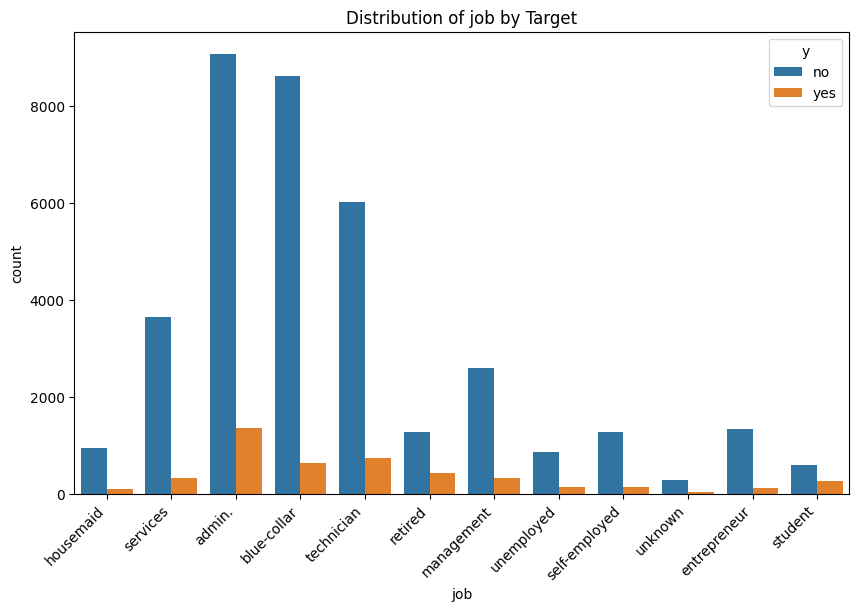

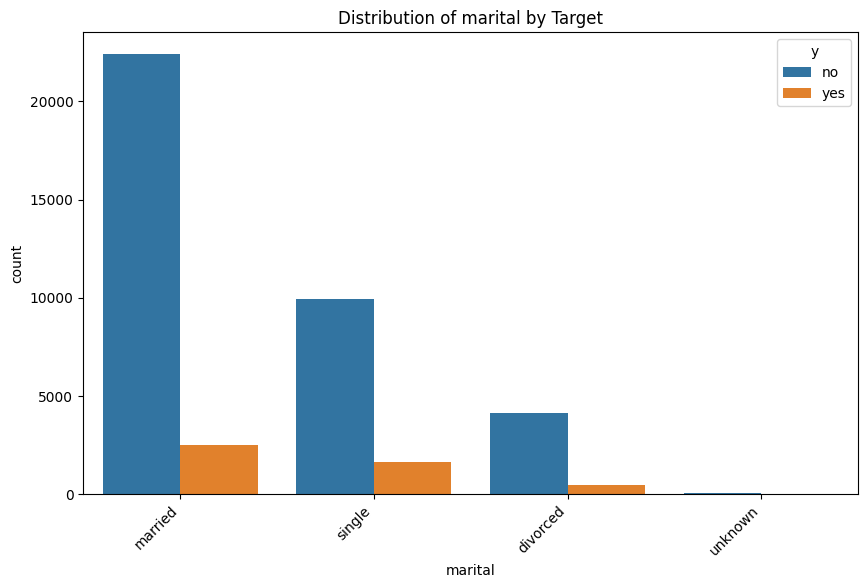

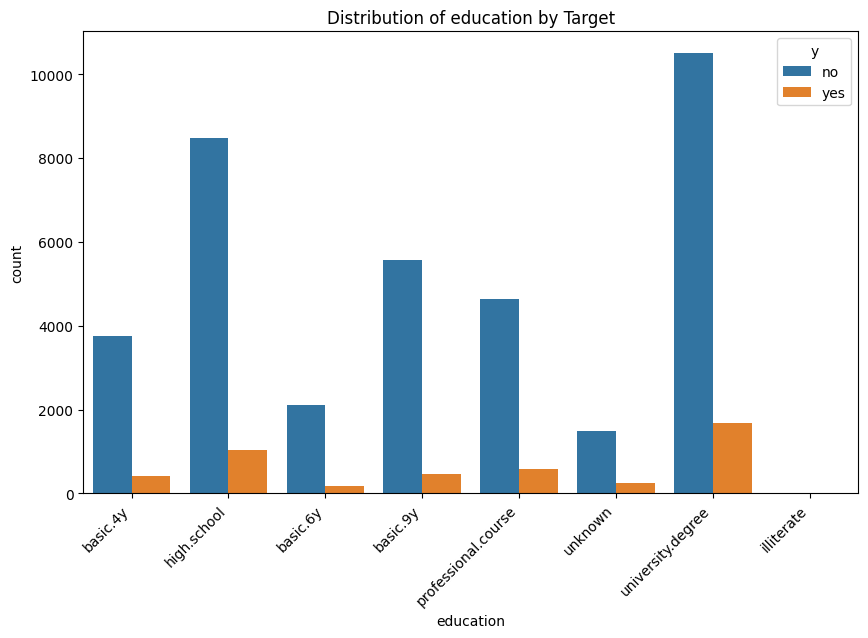

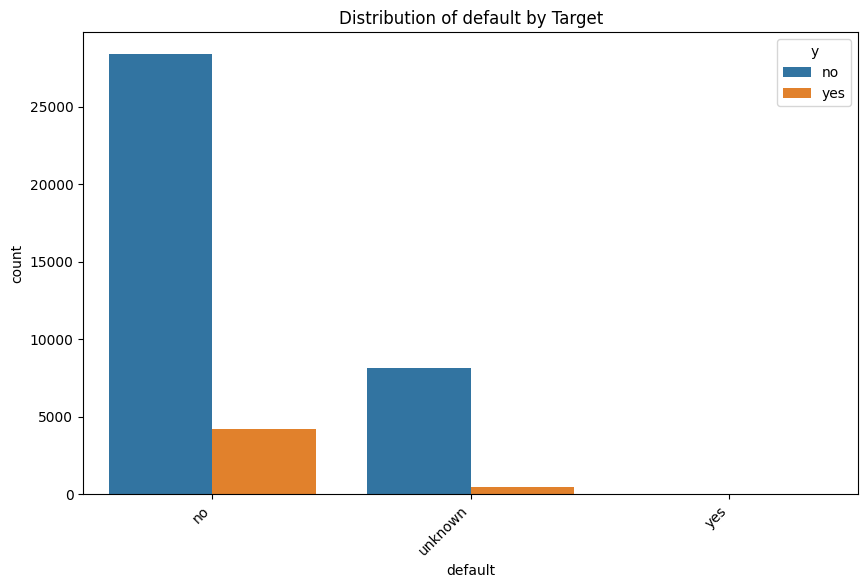

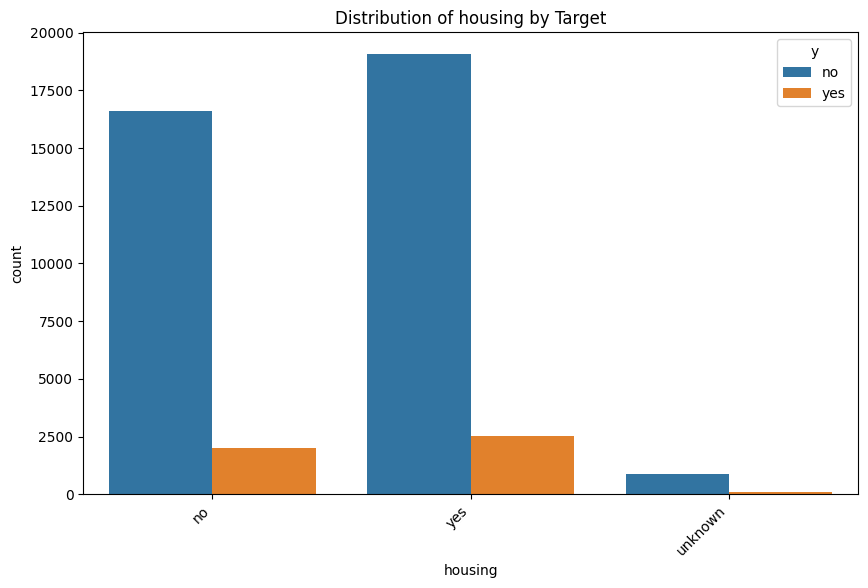

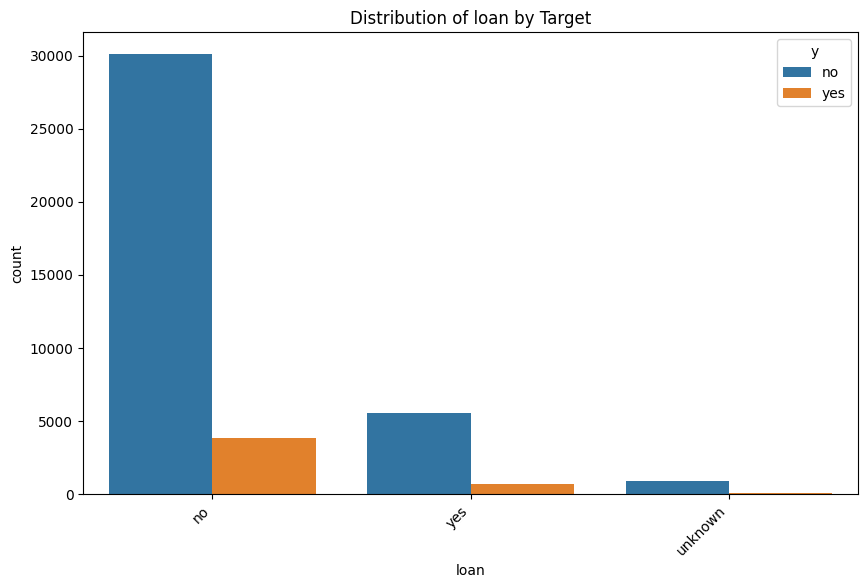

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualisasi setiap fitur untuk melihat sebaran data unknown

categoric_with_unknown = ['job', 'marital', 'education', 'default', 'housing', 'loan']

for col in categoric_with_unknown:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f'Distribution of {col} by Target')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [29]:
# Calculate the percentage of 'unknown' data for each specified column
for col in categoric_with_unknown:
    unknown_count = df[df[col] == 'unknown'].shape[0]
    total_count = df.shape[0]
    percentage = (unknown_count / total_count) * 100
    print(f"Percentage of 'unknown' in '{col}': {percentage:.2f}%")

Percentage of 'unknown' in 'job': 0.80%
Percentage of 'unknown' in 'marital': 0.19%
Percentage of 'unknown' in 'education': 4.20%
Percentage of 'unknown' in 'default': 20.88%
Percentage of 'unknown' in 'housing': 2.40%
Percentage of 'unknown' in 'loan': 2.40%


Dari hasil pesebaran setiap kolom hampir semuanya berada di bawah atau kurang dari 5%, kecuali kolom `default` memiliki proporsi data unknown sebesar 20.88%.

Kemungkinan besar data unknown akan diisi dengan Modus, dan fitur `Default` akan dicek terlebih dahulu untuk melakukan handling.

Lalu untuk handlingnya,
- fitur `job` akan diisi berdasarkan modus,
- fitur `education` juga akan diisi berdasarkan modus,
- untuk fitur `marital` akan diisi berdasarkan modus juga,
- dan untuk fitur `housing` dan `loan` akan diisi berdasarkan modus fitur `marital`. Tetapi akan melalui uji statistik terlebih dahulu untuk memastikan hubunganya.

### Handling Per Fitur

#### Fitur `Job`

In [30]:
# Handling fitur job dengan modus
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['job'].value_counts()

job
admin.           10749
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: count, dtype: int64

#### Fitur `Education`

In [31]:
# Handling fitur education dengan modus
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])
df['education'].value_counts()

education
university.degree      13894
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
illiterate                18
Name: count, dtype: int64

#### Fitur `Marital`

In [32]:
# Handling fitur marital dengan modus
df['marital'] = df['marital'].replace('unknown', df['marital'].mode()[0])
df['marital'].value_counts()

marital
married     25001
single      11564
divorced     4611
Name: count, dtype: int64

#### Fitur `Housing` & `Loan`

Kami akan melalui uji statistik terlebih dahulu untuk memastikan hubunganya.

In [33]:
from scipy.stats import chi2_contingency

#  Uji statistik fitur housing dan loan terhadap marital

# Housing and Loan vs Marital Status
# Perform chi-squared test for independence
chi2_housing_marital, p_housing_marital, dof_housing_marital, expected_housing_marital = chi2_contingency(pd.crosstab(df['housing'], df['marital']))
chi2_loan_marital, p_loan_marital, dof_loan_marital, expected_loan_marital = chi2_contingency(pd.crosstab(df['loan'], df['marital']))

print(f"Chi-squared test results for Housing vs Marital:")
print(f"Chi-squared statistic: {chi2_housing_marital:.4f}")
print(f"P-value: {p_housing_marital:.4f}")

print(f"\nChi-squared test results for Loan vs Marital:")
print(f"Chi-squared statistic: {chi2_loan_marital:.4f}")
print(f"P-value: {p_loan_marital:.4f}")

# Interpretation (assuming alpha = 0.05)
alpha = 0.05
if p_housing_marital < alpha:
    print("\nThere is a statistically significant relationship between Housing and Marital status.")
else:
    print("\nThere is no statistically significant relationship between Housing and Marital status.")

if p_loan_marital < alpha:
    print("There is a statistically significant relationship between Loan and Marital status.")
else:
    print("There is no statistically significant relationship between Loan and Marital status.")

Chi-squared test results for Housing vs Marital:
Chi-squared statistic: 9.9206
P-value: 0.0418

Chi-squared test results for Loan vs Marital:
Chi-squared statistic: 2.9122
P-value: 0.5726

There is a statistically significant relationship between Housing and Marital status.
There is no statistically significant relationship between Loan and Marital status.


Hasilnya, hanya `housing` yang memiliki hubungan signifikan/dipengaruhi oleh `marital` (status pernikahan).

Maka dari itu fitur `housing` akan diisi dengan modus berdasarkan `marital`, dan `loan` akan diisi dengan modus tanpa didasari fitur lain.

In [34]:
# Menghitung status housing yang paling sering muncul (mode) berdasarkan marital
housing_by_marital = df.groupby('marital')['housing'].agg(lambda x: x.mode()[0])
housing_by_marital

marital
divorced    yes
married     yes
single      yes
Name: housing, dtype: object

Setelah diketahui modus dari `housing` berdasarkan `marital`, maka kita bisa mengganti `housing` yang berisi unknown dengan modus `housing` berdasarkan `marital`.

##### Fitur `Housing`

In [35]:
df.loc[df['housing'] == 'unknown', 'housing'] = df.loc[df['housing'] == 'unknown', 'marital'].map(housing_by_marital)
df['housing'].value_counts()

housing
yes    22561
no     18615
Name: count, dtype: int64

##### Fitur `Loan`

In [36]:
# Handling fitur loan dengan modus
df['loan'] = df['loan'].replace('unknown', df['loan'].mode()[0])
df['loan'].value_counts()

loan
no     34928
yes     6248
Name: count, dtype: int64

#### Fitur `Default`

Fitur default merupakan status apakah klien punya kredit macet sebelumnya (yes/no). Fitur ini bisa menjadi indikasi risiko. Maka dari itu sebelum menghandling fitur ini harus di cek terlebih dahulu.

In [37]:
df['default'].value_counts()

default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64

Ada beberapa pertimbangan untuk mengandling fitur `default`, dimana fitur ini memiliki tiga nilai: 'no', 'unknown', dan 'yes'. Nilai 'no' merupakan yang paling dominan, sementara 'unknown' tidak memberikan informasi yang jelas apakah seorang pelanggan pernah gagal bayar atau tidak.

Keputusannya fitur ini akan dihapus karena menghandling 20.88% dari data tersebut sangat mempengaruhi prediksi target, dan kurangnya variasi data juga tidak memberikan kontribusi yang signifikan. Lalu dari domain knowledge nya, sistem pembayaran pada layanan deposito dilakukan di awal, sehingga informasi mengenai riwayat gagal bayar pelanggan menjadi kurang relevan.

In [38]:
# menghapus kolom default
df.drop('default', axis=1, inplace=True)

## Removing Data Leakage
Menghapus kolom `duration`, karena *data leakage* (hanya diketahui setelah panggilan). Menghapus `duration` memastikan model hanya menggunakan fitur yang tersedia sebelum kontak, sesuai dengan skenario prediksi *real-time*.

In [39]:
# Hapus kolom duration
df = df.drop('duration', axis=1)
print("Kolom setelah penghapusan:", df.columns)

# Validasi distribusi target setelah penghapusan
print("\nDistribusi target variable y setelah menghapus duration:\n", 
      df['y'].value_counts(normalize=True).round(3))

Kolom setelah penghapusan: Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y'],
      dtype='object')

Distribusi target variable y setelah menghapus duration:
 y
no     0.887
yes    0.113
Name: proportion, dtype: float64


Penambahan validasi distribusi `y` memastikan bahwa penghapusan `duration` tidak mengubah proporsi kelas (`yes` ~11.3%), yang penting untuk menjaga representasi kelas minoritas guna mencapai Recall ≥85%.

Langkah ini mendukung tujuan proyek dengan memastikan model hanya menggunakan fitur prediktif yang tersedia sebelum kampanye, meningkatkan relevansi untuk segmentasi klien.

## Handling Outliers
Menggunakan metode *capping* berdasarkan IQR untuk `age`, `campaign`, dan `cons.conf.idx`. *Capping* mempertahankan data outlier tanpa menghapusnya.

In [40]:
# Fungsi untuk capping outlier berdasarkan IQR
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Terapkan capping pada age, campaign, cons.conf.idx
for col in ['age', 'campaign', 'cons.conf.idx']:
    df = cap_outliers(df, col)

# Validasi distribusi setelah capping
for col in ['age', 'campaign', 'cons.conf.idx']:
    print(f"Statistik {col} setelah capping:\n", df[col].describe())

# Transformasi previous menjadi kategorikal
df['previous'] = df['previous'].apply(lambda x: 'contacted' if x > 0 else 'not_contacted')
print("Distribusi previous:\n", df['previous'].value_counts())

df['age'] = df['age'].astype(int)

# Validasi hubungan previous dengan target y
print("\nProporsi konversi berdasarkan previous:\n", 
      pd.crosstab(df['previous'], df['y'], normalize='index').round(3))

Statistik age setelah capping:
 count    41176.000000
mean        39.939236
std         10.128801
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         69.500000
Name: age, dtype: float64
Statistik campaign setelah capping:
 count    41176.000000
mean         2.275476
std          1.550606
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: campaign, dtype: float64
Statistik cons.conf.idx setelah capping:
 count    41176.000000
mean       -40.503405
std          4.626271
min        -50.800000
25%        -42.700000
50%        -41.800000
75%        -36.400000
max        -26.950000
Name: cons.conf.idx, dtype: float64
Distribusi previous:
 previous
not_contacted    35551
contacted         5625
Name: count, dtype: int64

Proporsi konversi berdasarkan previous:
 y                 no    yes
previous                   
contacted      0.734  0.266
not_contacted  0.912  0.088


## Final Validation and Saving

Periksa kembali dataset untuk memastikan tidak ada nilai "unknown", outlier ekstrem, atau inkonsistensi tipe data. Simpan dataset yang telah diproses sepenuhnya. Validasi memastikan dataset siap untuk EDA dan pemodelan tanpa masalah tersembunyi.


In [42]:
# Cek nilai "unknown" di kolom kategorikal awal
print("Pemeriksaan nilai 'unknown':")
for col in ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays', 'previous']:
    if col in df.columns and df[col].dtype == 'object':
        print(f"Jumlah 'unknown' di {col}:", (df[col] == 'unknown').sum())
    else:
        print(f"Kolom {col} sudah diencode.")

# Cek tipe data semua kolom
print("\nTipe data semua kolom:\n", df.dtypes)

# Cek nilai hilang
print("\nJumlah nilai hilang:\n", df.isna().sum())

# Simpan dataset
df.to_csv('../Data/data-clean.csv', index=False)
print("\nDataset tersimpan sebagai 'data-clean.csv'")

Pemeriksaan nilai 'unknown':
Jumlah 'unknown' di job: 0
Jumlah 'unknown' di marital: 0
Jumlah 'unknown' di education: 0
Jumlah 'unknown' di housing: 0
Jumlah 'unknown' di loan: 0
Jumlah 'unknown' di contact: 0
Jumlah 'unknown' di month: 0
Jumlah 'unknown' di day_of_week: 0
Jumlah 'unknown' di poutcome: 0
Kolom pdays sudah diencode.
Jumlah 'unknown' di previous: 0

Tipe data semua kolom:
 age                 int64
job                object
marital            object
education          object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous           object
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

Jumlah nilai hilang:
 age               0
job               0
marital           0
education         

# Preprocessing

## Feature Engineering

1. **Age Grouping**

    EDA menunjukkan usia 51+ memiliki probabilitas berlangganan lebih tinggi (~0.3-0.5). Pengelompokan ke `Young (<=30)`, `Middle (31-50)`, `Senior (51+)` menyederhanakan pola demografis.

2. **Financial Stability**

    Klien yang menikah tanpa pinjaman (`housing=no`, `loan=no`) memiliki probabilitas berlangganan ~0.5, sedangkan klien bercerai dengan pinjaman ~0.1. Fitur ini menggabungkan `marital`, `housing`, dan `loan`.

3. **Previous Campaign Success**

    `poutcome=success` memiliki probabilitas berlangganan ~0.6. Fitur biner ini menyoroti riwayat kampanye yang sukses.

4. **Campaign Frequency (with validation for no zero values)**

    Frekuensi kontak 3-4 kali optimal (~0.12). Kategorisasi `Low (<=2)`, `Optimal (3-4)`, `High (>4)` menangkap efektivitas kampanye.

5. **Economic Condition (adjusted cons.conf.idx threshold to < -45)**

    Kondisi ekonomi tidak stabil (`emp.var.rate < 0`, `euribor3m < 2`, `cons.conf.idx < -45`) meningkatkan minat deposito (~0.15). Ambang batas `-45` sesuai dengan rentang data (-50.8 hingga -36.4).

6. **Optimal Campaign Month**

    Bulan Maret dan April memiliki probabilitas berlangganan ~0.5. Fitur biner ini menyoroti waktu kampanye yang optimal.

7. **Economic Score (numerical combination of emp.var.rate, euribor3m, cons.conf.idx)**

    Menggabungkan `emp.var.rate`, `euribor3m`, dan `cons.conf.idx` menjadi skor numerik (rata-rata z-score) untuk menangkap variasi ekonomi secara halus.

8. **Has Previous Contact**

    Kolom `previous` ("contacted", "not_contacted") menunjukkan apakah klien pernah dikontak sebelumnya. Klien dengan `previous="contacted"` mungkin lebih responsif berdasarkan EDA.

9. **Pdays Grouping**

    `pdays` memiliki nilai 999 (tidak pernah dikontak) dan nilai numerik lainnya (misalnya, 3, 6). Pengelompokan ke `Never`, `Recent (<=7)`, `Long Ago (>7)` menangkap waktu sejak kontak terakhir, yang relevan untuk respons klien.

10. **High Subscription Job**

    Pekerjaan seperti `self-employed`, `retired`, dan `entrepreneur` memiliki probabilitas berlangganan lebih tinggi berdasarkan EDA.

11. **Binning untuk `nr.employed`**

    Mengubah `nr.employed` menjadi kategorikal untuk menangkap pola non-linear dan mempermudah interpretasi, seperti yang dilakukan pada `age`, `campaign`, dan `pdays`.

In [44]:
df_fe = pd.read_csv('../Data/data-clean.csv')

pd.set_option('display.max_columns', None)
df_fe

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,69,retired,married,professional.course,yes,no,cellular,nov,fri,1,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41172,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,1,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41173,56,retired,married,university.degree,yes,no,cellular,nov,fri,2,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41174,44,technician,married,professional.course,no,no,cellular,nov,fri,1,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [45]:
from sklearn.preprocessing import StandardScaler

# Fungsi untuk binning umur
def age_binning(age):
    """Mengubah umur menjadi kategori: Young, Middle, Senior."""
    try:
        if age <= 30:
            return 'Young (<=30)'
        elif 31 <= age <= 50:
            return 'Middle (31-50)'
        else:
            return 'Senior (51+)'
    except (TypeError, ValueError):
        return 'Unknown'

# Fungsi untuk stabilitas finansial
def financial_stability(row):
    """Menentukan stabilitas finansial berdasarkan marital, housing, dan loan."""
    try:
        if row['marital'] == 'married' and row['housing'] == 'no' and row['loan'] == 'no':
            return 'High'
        elif row['marital'] == 'divorced' and (row['housing'] == 'yes' or row['loan'] == 'yes'):
            return 'Low'
        else:
            return 'Medium'
    except:
        return 'Medium'

# Fungsi untuk frekuensi kampanye
def campaign_frequency(campaign):
    """Mengubah jumlah kontak kampanye menjadi kategori: Low, Optimal, High."""
    try:
        if campaign <= 2:
            return 'Low (<=2)'
        elif 3 <= campaign <= 4:
            return 'Optimal (3-4)'
        else:
            return 'High (>4)'
    except (TypeError, ValueError):
        return 'Low (<=2)'

# Fungsi untuk kondisi ekonomi
def economic_condition(row):
    """Menentukan kondisi ekonomi berdasarkan emp.var.rate, euribor3m, dan cons.conf.idx."""
    try:
        if row['emp.var.rate'] < 0 and row['euribor3m'] < 2 and row['cons.conf.idx'] < -45:
            return 'Unstable'
        else:
            return 'Stable'
    except:
        return 'Stable'

# Fungsi untuk binning pdays
def pdays_binning(pdays):
    """Mengubah pdays menjadi kategori: Never, Recent, Long Ago."""
    try:
        if pdays == 999:
            return 'Never'
        elif pdays <= 7:
            return 'Recent (<=7)'
        else:
            return 'Long Ago (>7)'
    except (TypeError, ValueError):
        return 'Never'

# Fungsi untuk binning nr.employed
def nr_employed_binning(nr_employed):
    """Mengubah nr.employed menjadi kategori: Good, Moderate, Poor."""
    try:
        if nr_employed <= 5000:
            return 'Good (<=5000)'
        elif 5001 <= nr_employed <= 5200:
            return 'Moderate (5001-5200)'
        else:
            return 'Poor (>5200)'
    except (TypeError, ValueError):
        return 'Moderate (5001-5200)'

# Feature Engineering
def apply_feature_engineering(df_fe):
    """Menerapkan semua transformasi feature engineering."""
    df_fe = df_fe.copy()  # Hindari modifikasi DataFrame asli

    # 1. Age binning
    df_fe['age_group'] = df_fe['age'].apply(age_binning)

    # 2. Financial stability
    df_fe['financial_stability'] = df_fe.apply(financial_stability, axis=1)

    # 3. Previous success
    df_fe['previous_success'] = df_fe['poutcome'].apply(lambda x: 1 if x == 'success' else 0)

    # 4. Campaign frequency
    df_fe['campaign_frequency'] = df_fe['campaign'].apply(campaign_frequency)

    # 5. Economic condition
    df_fe['economic_condition'] = df_fe.apply(economic_condition, axis=1)

    # 6. Optimal month
    df_fe['optimal_month'] = df_fe['month'].apply(lambda x: 1 if x in ['mar', 'apr'] else 0)

    # 7. Economic score
    scaler = StandardScaler()
    economic_cols = ['emp.var.rate', 'euribor3m', 'cons.conf.idx']
    df_fe['econ_score'] = scaler.fit_transform(df_fe[economic_cols]).mean(axis=1)

    # 8. Previous contact
    df_fe['has_previous_contact'] = df_fe['previous'].apply(lambda x: 1 if x == 'contacted' else 0)

    # 9. Pdays binning
    df_fe['pdays_group'] = df_fe['pdays'].apply(pdays_binning)

    # 10. High subscription job
    high_subscription_jobs = ['self-employed', 'retired', 'entrepreneur']
    df_fe['high_subscription_job'] = df_fe['job'].apply(lambda x: 1 if x in high_subscription_jobs else 0)

    # 11. Binning nr.employed
    df_fe['nr_employed_group'] = df_fe['nr.employed'].apply(nr_employed_binning)

    return df_fe

In [48]:
# Terapkan feature engineering
df_fe = apply_feature_engineering(df_fe)

# Verifikasi hasil
print("\nDistribusi fitur kategorikal baru:")
print("\nage_group:")
print(df_fe['age_group'].value_counts())
print("\nfinancial_stability:")
print(df_fe['financial_stability'].value_counts())
print("\ncampaign_frequency:")
print(df_fe['campaign_frequency'].value_counts())
print("\neconomic_condition:")
print(df_fe['economic_condition'].value_counts())
print("\npdays_group:")
print(df_fe['pdays_group'].value_counts())
print("\nnr_employed_group:")
print(df_fe['nr_employed_group'].value_counts())

# Tampilkan daftar kolom
print("\nKolom di df_fe setelah feature engineering:")
print(df_fe.columns.tolist())

# Tampilkan statistik nr.employed untuk verifikasi binning
print("\nStatistik nr.employed:")
print(df_fe['nr.employed'].describe())

# Simpan DataFrame hasil feature engineering
df_fe.to_csv('../Data/data-feature-engineering.csv', index=False)
print("\nDataFrame disimpan ke './Data/data_fe.csv'")


Distribusi fitur kategorikal baru:

age_group:
age_group
Middle (31-50)    26617
Young (<=30)       7381
Senior (51+)       7178
Name: count, dtype: int64

financial_stability:
financial_stability
Medium    28504
High       9871
Low        2801
Name: count, dtype: int64

campaign_frequency:
campaign_frequency
Low (<=2)        28202
Optimal (3-4)     7990
High (>4)         4984
Name: count, dtype: int64

economic_condition:
economic_condition
Stable      32312
Unstable     8864
Name: count, dtype: int64

pdays_group:
pdays_group
Never            39661
Recent (<=7)      1177
Long Ago (>7)      338
Name: count, dtype: int64

nr_employed_group:
nr_employed_group
Moderate (5001-5200)    23540
Poor (>5200)            16228
Good (<=5000)            1408
Name: count, dtype: int64

Kolom di df_fe setelah feature engineering:
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',

In [49]:
df_features = pd.read_csv('../Data/data-feature-engineering.csv')
df_features

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,financial_stability,previous_success,campaign_frequency,economic_condition,optimal_month,econ_score,has_previous_contact,pdays_group,high_subscription_job,nr_employed_group
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Senior (51+),High,0,Low (<=2),Stable,0,0.749185,0,Never,0,Moderate (5001-5200)
1,57,services,married,high.school,no,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Senior (51+),High,0,Low (<=2),Stable,0,0.749185,0,Never,0,Moderate (5001-5200)
2,37,services,married,high.school,yes,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Middle (31-50),Medium,0,Low (<=2),Stable,0,0.749185,0,Never,0,Moderate (5001-5200)
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Middle (31-50),High,0,Low (<=2),Stable,0,0.749185,0,Never,0,Moderate (5001-5200)
4,56,services,married,high.school,no,yes,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Senior (51+),Medium,0,Low (<=2),Stable,0,0.749185,0,Never,0,Moderate (5001-5200)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,69,retired,married,professional.course,yes,no,cellular,nov,fri,1,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,Senior (51+),Medium,0,Low (<=2),Unstable,0,-1.491102,0,Never,1,Good (<=5000)
41172,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,1,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,Middle (31-50),High,0,Low (<=2),Unstable,0,-1.491102,0,Never,0,Good (<=5000)
41173,56,retired,married,university.degree,yes,no,cellular,nov,fri,2,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,Senior (51+),Medium,0,Low (<=2),Unstable,0,-1.491102,0,Never,1,Good (<=5000)
41174,44,technician,married,professional.course,no,no,cellular,nov,fri,1,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,Middle (31-50),High,0,Low (<=2),Unstable,0,-1.491102,0,Never,0,Good (<=5000)


# Explanatory Data Analysis (EDA)

Tujuan

- Mengidentifikasi pola dan hubungan antara fitur dan variabel target `y` untuk menemukan faktor kunci kesuksesan kampanye.
- Memberikan wawasan untuk optimasi strategi pemasaran, termasuk metode kampanye terbaik, waktu kontak optimal (bulan/hari), dan segmentasi klien prioritas (berdasarkan pekerjaan/pendidikan/status/usia).
- Menyediakan visualisasi dan analisis statistik untuk mendukung pengambilan keputusan berbasis data.

In [1]:
#Library
import os
import warnings
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

# Statistik
from scipy.stats import (
    uniform, randint, shapiro, kstest, anderson, chi2_contingency, normaltest
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualisasi
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

# Preprocessing
import category_encoders as ce
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

# Train-test split & Model Selection
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold, cross_val_score, cross_validate,
    GridSearchCV, RandomizedSearchCV
)

# Feature Selection
from sklearn.feature_selection import SelectPercentile, SelectFromModel

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Model Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, make_scorer, precision_recall_curve
)

# Konfigurasi
warnings.filterwarnings("ignore")
os.environ['LIGHTGBM_VERBOSITY'] = '-1'

In [4]:
# load dataset
df = pd.read_csv('../Data/data-feature-engineering.csv')
df

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,...,y,age_group,financial_stability,previous_success,campaign_frequency,economic_condition,econ_score,has_previous_contact,pdays_group,high_subscription_job
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,...,no,Senior (51+),High,0,Low (<=2),Stable,0.749185,0,Never,0
1,57,services,married,high.school,no,no,telephone,may,mon,1,...,no,Senior (51+),High,0,Low (<=2),Stable,0.749185,0,Never,0
2,37,services,married,high.school,yes,no,telephone,may,mon,1,...,no,Middle (31-50),Medium,0,Low (<=2),Stable,0.749185,0,Never,0
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,...,no,Middle (31-50),High,0,Low (<=2),Stable,0.749185,0,Never,0
4,56,services,married,high.school,no,yes,telephone,may,mon,1,...,no,Senior (51+),Medium,0,Low (<=2),Stable,0.749185,0,Never,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,69,retired,married,professional.course,yes,no,cellular,nov,fri,1,...,yes,Senior (51+),Medium,0,Low (<=2),Unstable,-1.491102,0,Never,1
41172,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,1,...,no,Middle (31-50),High,0,Low (<=2),Unstable,-1.491102,0,Never,0
41173,56,retired,married,university.degree,yes,no,cellular,nov,fri,2,...,no,Senior (51+),Medium,0,Low (<=2),Unstable,-1.491102,0,Never,1
41174,44,technician,married,professional.course,no,no,cellular,nov,fri,1,...,yes,Middle (31-50),High,0,Low (<=2),Unstable,-1.491102,0,Never,0


## Based on Perilaku Individual dan Kampanye

### Distribusi Kelas Berlangganan (y)

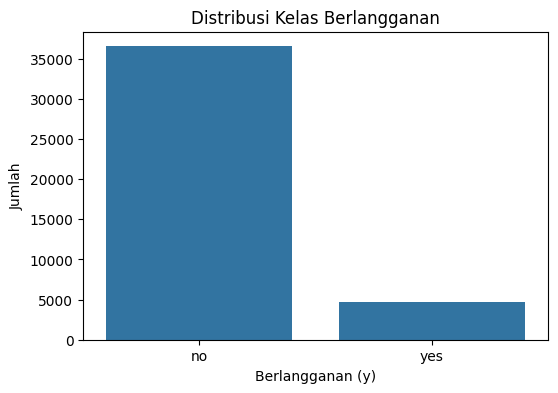

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='y')
plt.title('Distribusi Kelas Berlangganan')
plt.xlabel('Berlangganan (y)')
plt.ylabel('Jumlah')
plt.show()

**Interpretasi:**
Distribusi target menunjukkan **ketimpangan kelas yang signifikan**, di mana hanya sekitar **11%** dari nasabah yang berlangganan produk deposito berjangka (`y = yes`), sedangkan sisanya tidak (`y = no`).

**Aksi:**

* Terapkan metode penyeimbangan data seperti **SMOTE** atau **class weighting** untuk mengurangi bias model terhadap kelas mayoritas.
* Fokus pada **Recall** dalam evaluasi model, mengingat biaya kehilangan calon pelanggan potensial (False Negative) jauh lebih tinggi dibanding False Positive.

### Distribusi Usia dengan Boxplot Berdasarkan Berlangganan

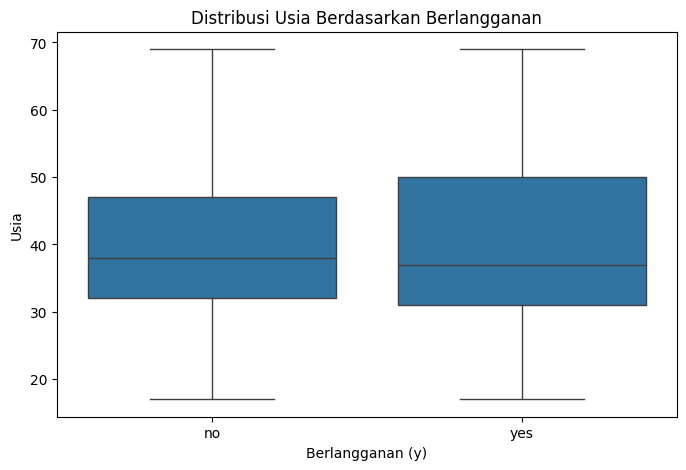

In [6]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='y', y='age')
plt.title('Distribusi Usia Berdasarkan Berlangganan')
plt.xlabel('Berlangganan (y)')
plt.ylabel('Usia')
plt.show()

**Interpretasi:**
Meskipun median usia relatif serupa antara kedua kelas, terdapat kecenderungan bahwa nasabah yang berlangganan memiliki sebaran usia yang lebih tinggi, terutama pada rentang **30–60 tahun**.

**Aksi:**

* Lakukan segmentasi usia, khususnya pada kelompok usia produktif (30–60 tahun), yang menunjukkan potensi lebih besar.
* Pertimbangkan untuk melakukan **feature binning** pada variabel usia agar dapat menangkap pola non-linear.

### Korelasi Pekerjaan dan Berlangganan

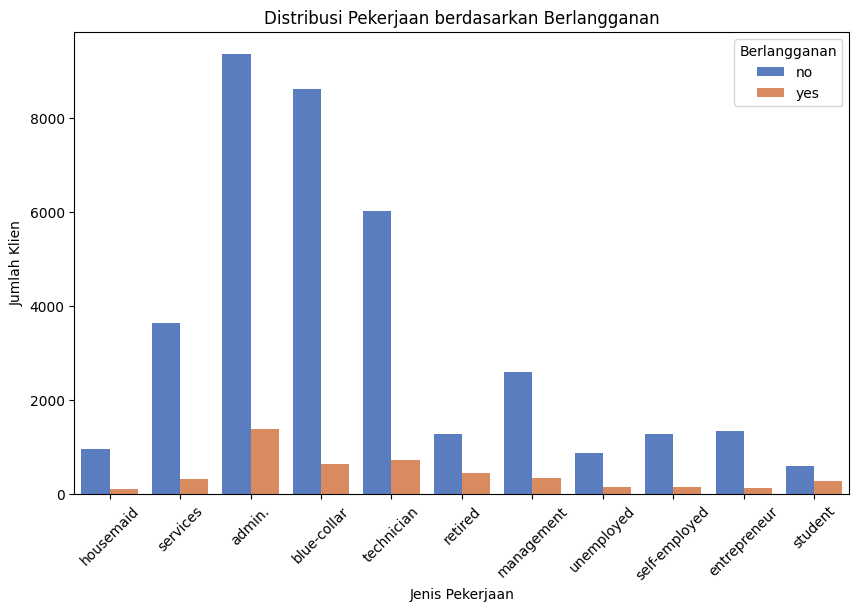

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='job', hue='y', data=df, palette='muted')
plt.title('Distribusi Pekerjaan berdasarkan Berlangganan')
plt.xlabel('Jenis Pekerjaan')
plt.ylabel('Jumlah Klien')
plt.xticks(rotation=45)
plt.legend(title='Berlangganan')
plt.show()

**Interpretasi:**

Target kampanye bisa difokuskan ke pekerjaan dengan rasio “yes” yang tinggi (misalnya: student, retired, admin.).

Segmen seperti blue-collar atau services mungkin perlu pendekatan yang berbeda atau tidak terlalu diutamakan.

### Pengaruh Pendidikan terhadap Berlangganan

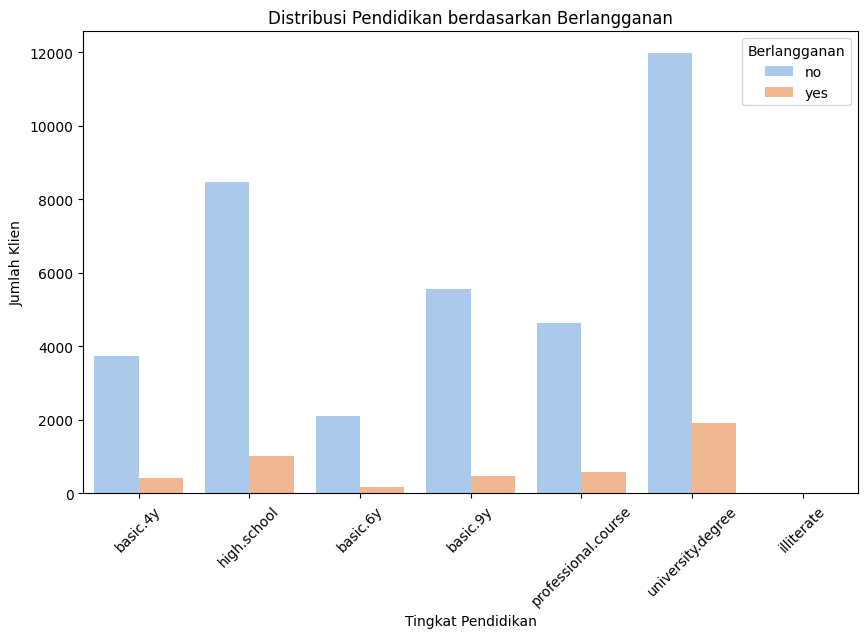

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='education', hue='y', data=df, palette='pastel')
plt.title('Distribusi Pendidikan berdasarkan Berlangganan')
plt.xlabel('Tingkat Pendidikan')
plt.ylabel('Jumlah Klien')
plt.xticks(rotation=45)
plt.legend(title='Berlangganan')
plt.show()

**Interpretasi:**

Mayoritas klien berasal dari kelompok pendidikan university degree dan high school.
Kelompok pendidikan tinggi seperti university degree dan professional course juga 
menunjukkan jumlah pelanggan yang berlangganan (yes) paling banyak, menandakan mereka lebih tertarik atau mampu mengambil produk deposito.

### Analisis Hasil Kampanye Sebelumnya (poutcome)

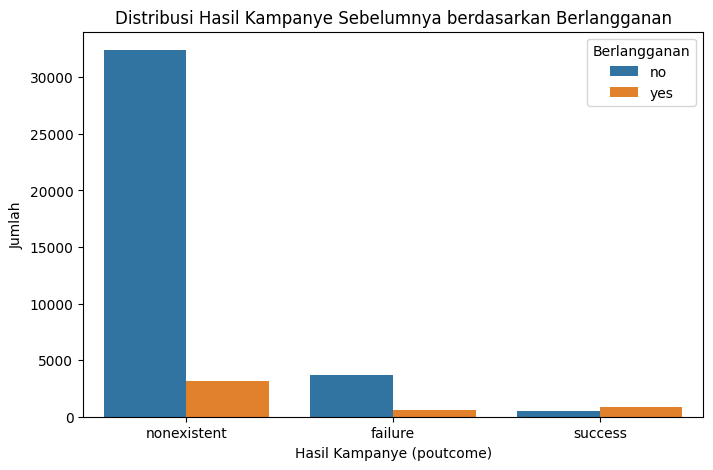

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='poutcome', hue='y')
plt.title('Distribusi Hasil Kampanye Sebelumnya berdasarkan Berlangganan')
plt.xlabel('Hasil Kampanye (poutcome)')
plt.ylabel('Jumlah')
plt.legend(title='Berlangganan')
plt.show()

**Interpretasi:**

Mayoritas klien sebelumnya tidak pernah ikut kampanye (nonexistent), namun dari kelompok ini tetap ada yang berhasil dikonversi.

Klien dengan riwayat kampanye gagal (failure) memiliki rasio berlangganan sangat rendah, menunjukkan efek negatif dari pengalaman buruk sebelumnya.

Sebaliknya, klien dengan riwayat kampanye berhasil (success) memiliki rasio konversi tinggi, meskipun jumlahnya kecil — menandakan bahwa pengalaman positif di masa lalu meningkatkan peluang keberhasilan kampanye saat ini.

### Korelasi Numerik (Heatmap)

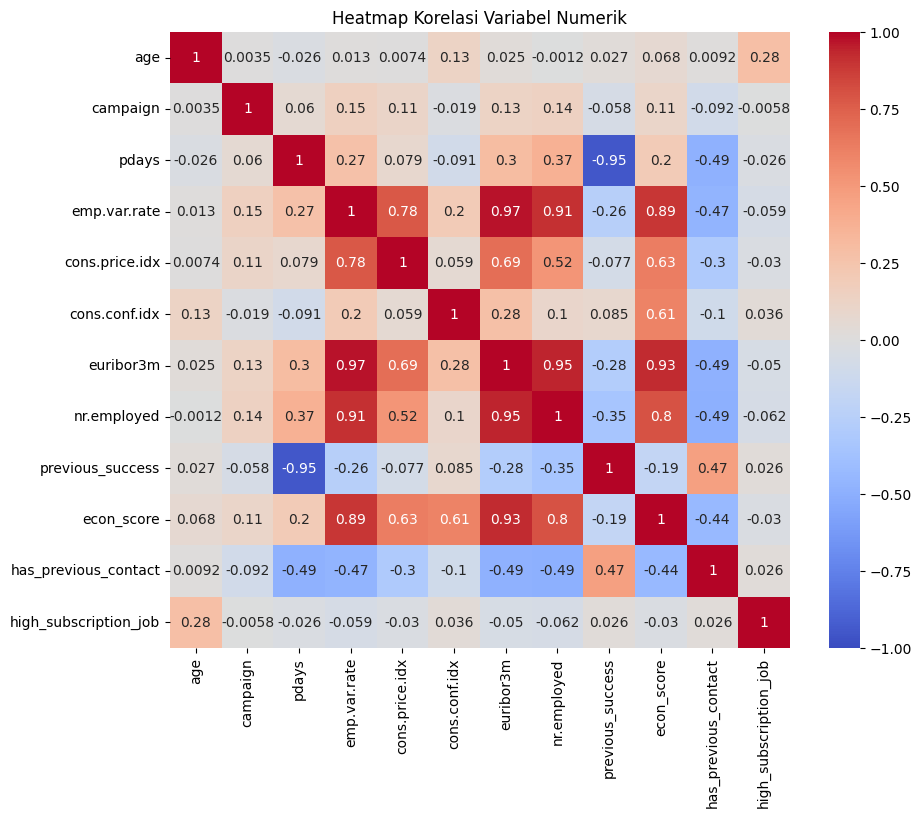

In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap Korelasi Variabel Numerik')
plt.show()

**Interpretasi:**

Terdapat korelasi tinggi antar variabel ekonomi makro seperti 
`emp.var.rate`, `euribor3m`, dan `nr.employed`. 

Sementara variabel seperti `age`, `campaign`, dan `pdays` tidak menunjukkan korelasi kuat, 
menandakan independensi yang baik sebagai prediktor.

**Aksi:**

* Perhatikan potensi **multikolinearitas** di antara variabel ekonomi. Pertimbangkan teknik seperti **PCA** atau regularisasi jika menggunakan model linear.
* Gunakan fitur independen seperti `campaign`, `age`, dan `pdays` sebagai input penting dalam model prediktif.

## Based on Perilaku Ekonomi Makro

### Distribusi Tingkat Variasi Tenaga Kerja (emp.var.rate) Berdasarkan Berlangganan

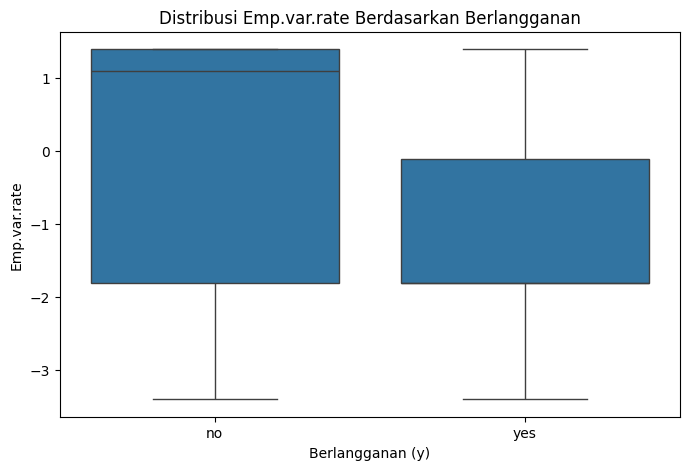

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='y', y='emp.var.rate')
plt.title('Distribusi Emp.var.rate Berdasarkan Berlangganan')
plt.xlabel('Berlangganan (y)')
plt.ylabel('Emp.var.rate')
plt.show()

**Interpretasi:**

Klien yang berlangganan cenderung berada pada periode dengan `emp.var.rate` negatif, menunjukkan minat terhadap deposito meningkat saat kondisi ekonomi memburuk.
Sebaliknya, saat `emp.var.rate` positif (ekonomi baik), lebih banyak klien yang tidak berlangganan.

Artinya: Deposito lebih diminati saat ekonomi sedang lesu.


### Distribusi Indeks Harga Konsumen (cons.price.idx) Berdasarkan Berlangganan

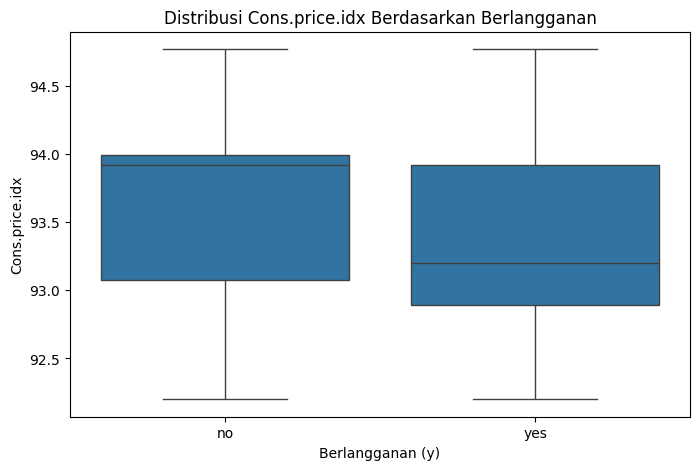

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='y', y='cons.price.idx')
plt.title('Distribusi Cons.price.idx Berdasarkan Berlangganan')
plt.xlabel('Berlangganan (y)')
plt.ylabel('Cons.price.idx')
plt.show()

**Interpretasi:**

Distribusi `cons.price.idx` antara nasabah yang berlangganan dan tidak berlangganan relatif mirip. Median, kuartil, dan sebarannya menunjukkan perbedaan yang sangat kecil.

Klien lebih banyak berlangganan saat cons.price.idx (indeks harga konsumen) lebih rendah.
Saat CPI tinggi, minat terhadap deposito menurun — kemungkinan karena prioritas kebutuhan harian meningkat.

Deposito lebih diminati saat inflasi konsumen rendah.



### Distribusi Indeks Kepercayaan Konsumen (cons.conf.idx) Berdasarkan Berlangganan

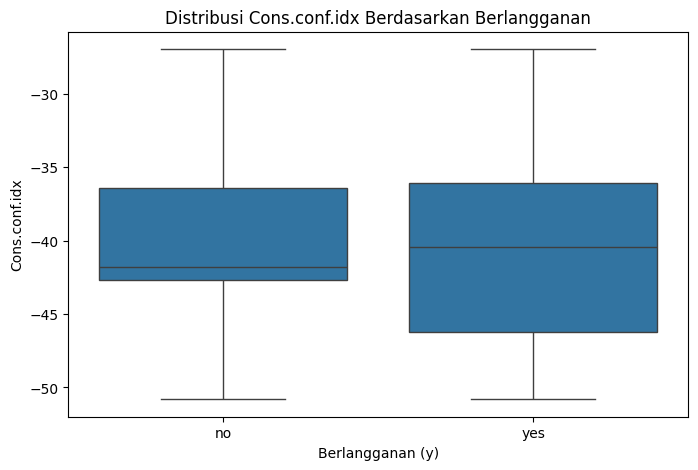

In [13]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='y', y='cons.conf.idx')
plt.title('Distribusi Cons.conf.idx Berdasarkan Berlangganan')
plt.xlabel('Berlangganan (y)')
plt.ylabel('Cons.conf.idx')
plt.show()

**Interpretasi:**

Nasabah yang berlangganan cenderung berada pada periode ketika indeks kepercayaan konsumen (`cons.conf.idx`) bernilai rendah (lebih pesimis). Nasabah lebih banyak berlangganan saat cons.conf.idx (indeks kepercayaan konsumen) lebih rendah atau negatif ekstrem.
Ini menunjukkan bahwa ketika kepercayaan konsumen rendah, minat terhadap deposito justru meningkat — mungkin karena klien mencari instrumen yang lebih aman.

Deposito cenderung dipilih saat konsumen merasa tidak yakin dengan kondisi ekonomi.


### Distribusi Tingkat Euribor 3 Bulan (euribor3m) Berdasarkan Berlangganan

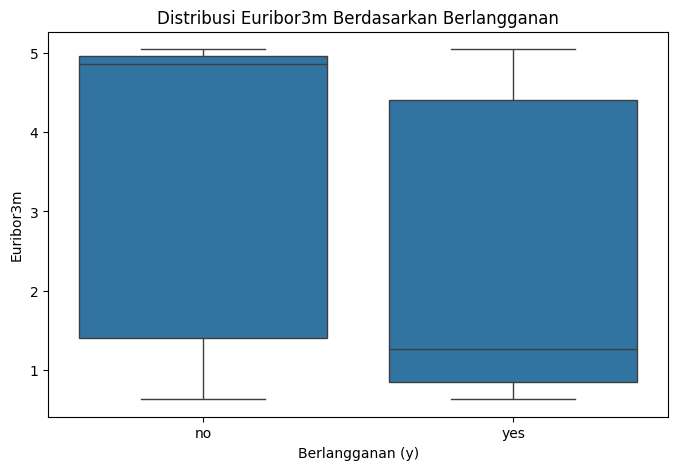

In [14]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='y', y='euribor3m')
plt.title('Distribusi Euribor3m Berdasarkan Berlangganan')
plt.xlabel('Berlangganan (y)')
plt.ylabel('Euribor3m')
plt.show()

**Interpretasi:**

Distribusi memperlihatkan bahwa mayoritas nasabah yang berlangganan terjadi saat nilai `euribor3m` rendah. Nilai tinggi justru diasosiasikan dengan tingkat berlangganan yang rendah. 

Nasabah lebih banyak berlangganan saat euribor3m (suku bunga antarbank Eropa 3 bulan) berada di level rendah.
Sebaliknya, saat euribor3m tinggi, mayoritas klien justru tidak berlangganan.

Deposito cenderung diminati saat suku bunga acuan rendah, kemungkinan karena alternatif investasi lain kurang menarik.

### Distribusi Jumlah Karyawan (nr.employed) Berdasarkan Berlangganan

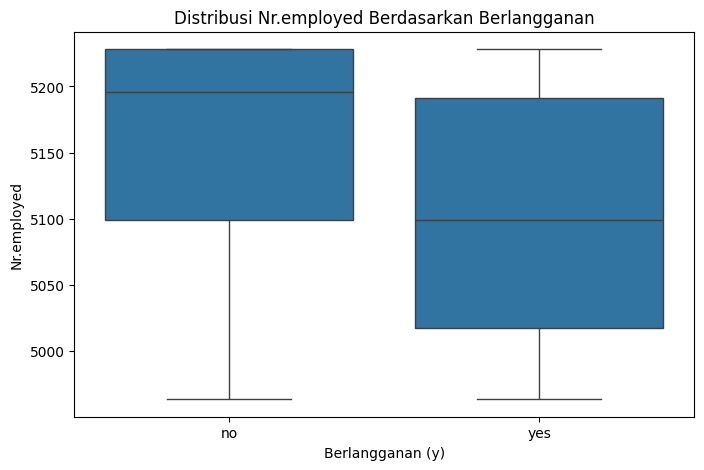

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='y', y='nr.employed')
plt.title('Distribusi Nr.employed Berdasarkan Berlangganan')
plt.xlabel('Berlangganan (y)')
plt.ylabel('Nr.employed')
plt.show()

**Interpretasi:**

Sebagian besar nasabah yang berlangganan berada pada saat `nr.employed` relatif lebih rendah, yang merefleksikan pasar tenaga kerja yang sedang melemah atau ketidakpastian ekonomi.

Sebaliknya, saat jumlah tenaga kerja tinggi, mayoritas klien justru tidak berlangganan.

Deposito lebih diminati saat kondisi ketenagakerjaan menurun, karena ketidakpastian ekonomi mendorong preferensi pada instrumen yang lebih aman.

### Heatmap Korelasi Variabel Ekonomi Makro

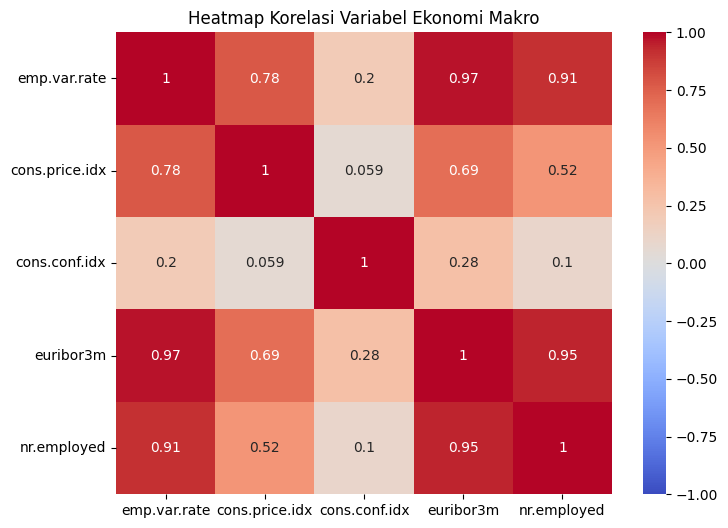

In [16]:
macro_cols = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
plt.figure(figsize=(8, 6))
sns.heatmap(df[macro_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap Korelasi Variabel Ekonomi Makro')
plt.show()

**Interpretasi:**

Heatmap menunjukkan korelasi sangat tinggi antara beberapa variabel:

* `emp.var.rate` ↔ `euribor3m` (r = 0.97)
* `emp.var.rate` ↔ `nr.employed` (r = 0.91)
* `euribor3m` ↔ `nr.employed` (r = 0.95)

**Aksi:**

* Perlu mitigasi terhadap potensi multikolinearitas saat digunakan dalam model prediktif berbasis regresi/logistik.
* Untuk model berbasis pohon (*tree-based models* seperti XGBoost atau Random Forest), korelasi tinggi ini tidak menjadi masalah besar, tetapi sebaiknya tetap dilakukan validasi terhadap *feature importance* untuk menghindari redundansi informasi.

## Korelasi Antar Variabel

### ⁠Segmen usia vs pendidikan dengan berlangganan

<Figure size 1000x600 with 0 Axes>

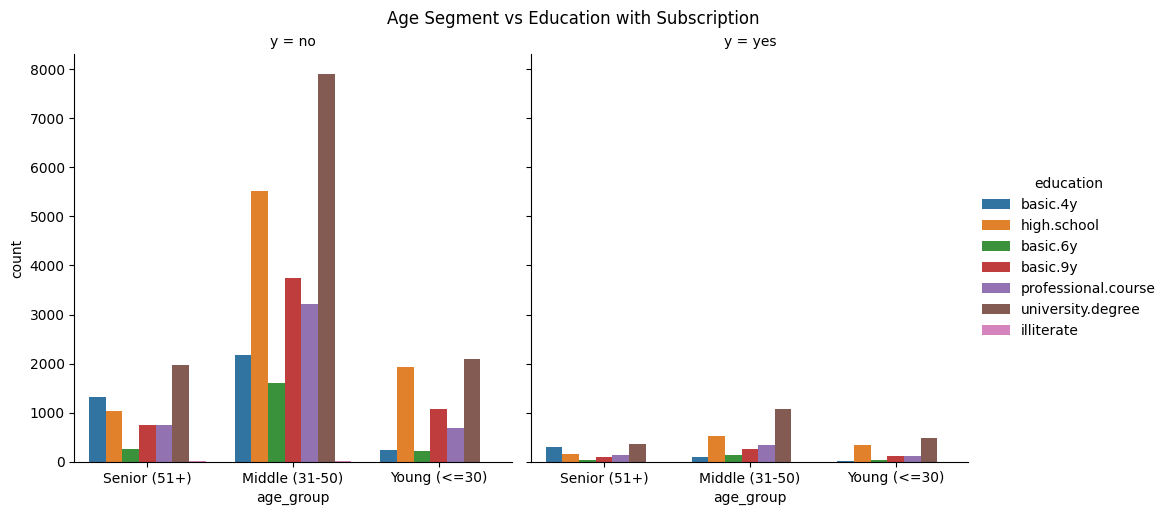

In [17]:
plt.figure(figsize=(10, 6))
sns.catplot(x='age_group', hue='education', col='y', data=df, kind='count', col_wrap=2)
plt.suptitle('Age Segment vs Education with Subscription', y=1.02)
plt.show()

**Interpretasi**: 

* **Usia Menengah Dominan:** Kelompok usia **31-50 tahun (Menengah)** memiliki jumlah tertinggi untuk yang berlangganan maupun tidak, di hampir semua tingkat pendidikan.
* **Pendidikan Tinggi Paling Umum:** 'university.degree' dan 'high.school' adalah tingkat pendidikan yang paling sering terlihat, baik di kalangan pelanggan maupun non-pelanggan.
* **Kelompok Usia Lain Kurang Berlangganan:** Usia Senior (51+) dan Muda (<=30) memiliki jumlah langganan yang jauh lebih rendah dibandingkan usia Menengah.
* **'illiterate' Sangat Jarang:** Kategori 'illiterate' sangat kecil di semua segmen.

**Kesimpulan :** Pelanggan cenderung berasal dari kelompok usia menengah (31-50 tahun) dengan pendidikan tinggi ('university.degree' atau 'high.school'), meskipun kelompok ini juga merupakan bagian terbesar dari non-pelanggan.

### Pekerjaan dan Stabilitas Kampanye

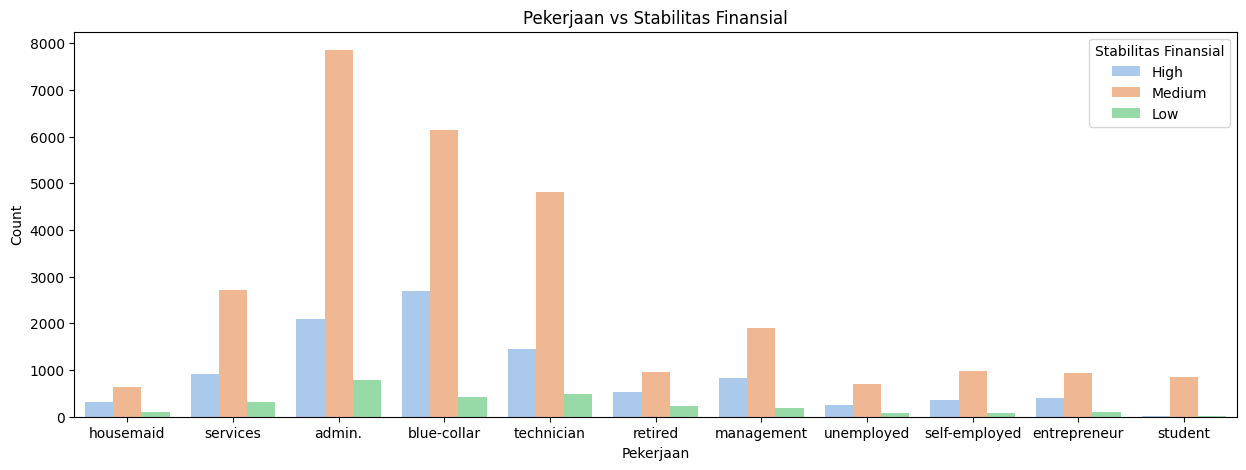

In [18]:

plt.figure(figsize=(15, 5))
sns.countplot(x='job', hue='financial_stability', data=df, palette='pastel')
plt.title('Pekerjaan vs Stabilitas Finansial')
plt.xlabel('Pekerjaan')
plt.ylabel('Count')
plt.legend(title='Stabilitas Finansial')
plt.show()

**Interpretasi**:

* **Pekerjaan Dominan:** Pekerjaan 'admin.', 'blue-collar', dan 'technician' memiliki jumlah individu terbanyak secara keseluruhan.
* **Stabilitas Finansial 'Medium' Paling Banyak:** Hampir di semua jenis pekerjaan, kategori 'Stabilitas Finansial' yang paling dominan adalah 'Medium' (batang oranye), menunjukkan bahwa sebagian besar individu berada pada tingkat stabilitas finansial menengah.
* **Pekerjaan dengan Stabilitas 'High':**
    * 'admin.' memiliki jumlah tertinggi individu dengan stabilitas finansial 'High' (batang biru muda), diikuti oleh 'blue-collar' dan 'technician'.
    * 'management' juga memiliki porsi 'High' yang cukup signifikan relatif terhadap totalnya.
* **Pekerjaan dengan Stabilitas 'Low':**
    * 'admin.' dan 'blue-collar' masih memiliki jumlah terbesar untuk stabilitas finansial 'Low' (batang hijau muda), namun proporsinya jauh lebih kecil dibandingkan 'Medium' atau 'High' dalam pekerjaan tersebut.
    * Beberapa pekerjaan seperti 'unemployed', 'self-employed', 'entrepreneur', dan 'student' juga memiliki representasi 'Low' yang tidak signifikan.
* **Pekerjaan dengan Jumlah Individu Sedikit:** Pekerjaan seperti 'unemployed', 'student', 'entrepreneur', 'self-employed', 'housemaid', dan 'retired' memiliki jumlah individu yang relatif lebih sedikit di semua kategori stabilitas finansial.

**Kesimpulan:**
Sebagian besar individu dalam dataset ini memiliki stabilitas finansial 'Medium'. Pekerjaan 'admin.', 'blue-collar', dan 'technician' adalah yang paling banyak populasinya, dan mereka juga memiliki kontribusi terbesar pada kategori stabilitas finansial 'High'.

### Demografis: Status Perkawinan dan Pinjaman

<Figure size 1000x600 with 0 Axes>

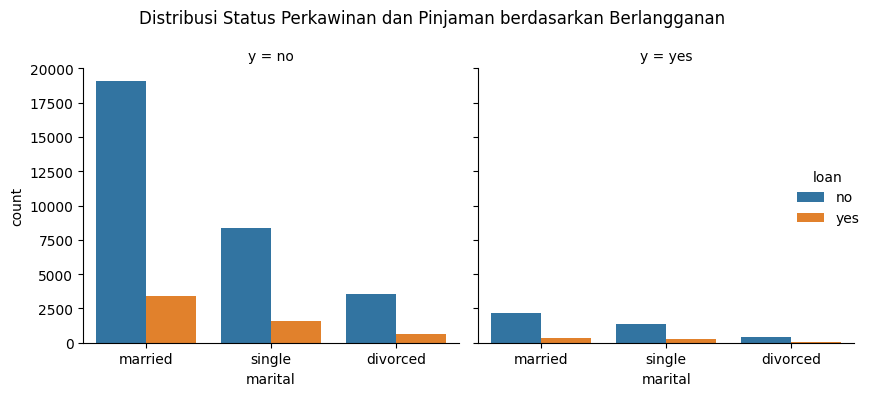

In [19]:
plt.figure(figsize=(10, 6))
sns.catplot(x='marital', hue='loan', col='y', data=df, kind='count', height=4, aspect=1)
plt.suptitle('Distribusi Status Perkawinan dan Pinjaman berdasarkan Berlangganan')
plt.tight_layout()
plt.show()

**Interpretasi**: 

* **'married' Paling Dominan:** Status perkawinan 'married' (menikah) adalah yang paling umum di kedua kelompok (berlangganan dan tidak), diikuti oleh 'single' dan 'divorced'.
* **Mayoritas Tanpa Pinjaman:** Baik di kalangan berlangganan maupun non-Berlangganan, mayoritas individu tidak memiliki pinjaman ('loan = no') dibandingkan dengan yang memiliki pinjaman ('loan = yes').

**Kesimpulan:** Berlangganan cenderung adalah individu yang sudah menikah dan tidak memiliki pinjaman, meskipun demografi ini juga merupakan mayoritas di antara non-Berlangganan. Secara umum, yang memiliki pinjaman ('loan = yes') cenderung berkorelasi dengan tingkat langganan yang lebih rendah.

### Temporal: Musiman dan Demografis


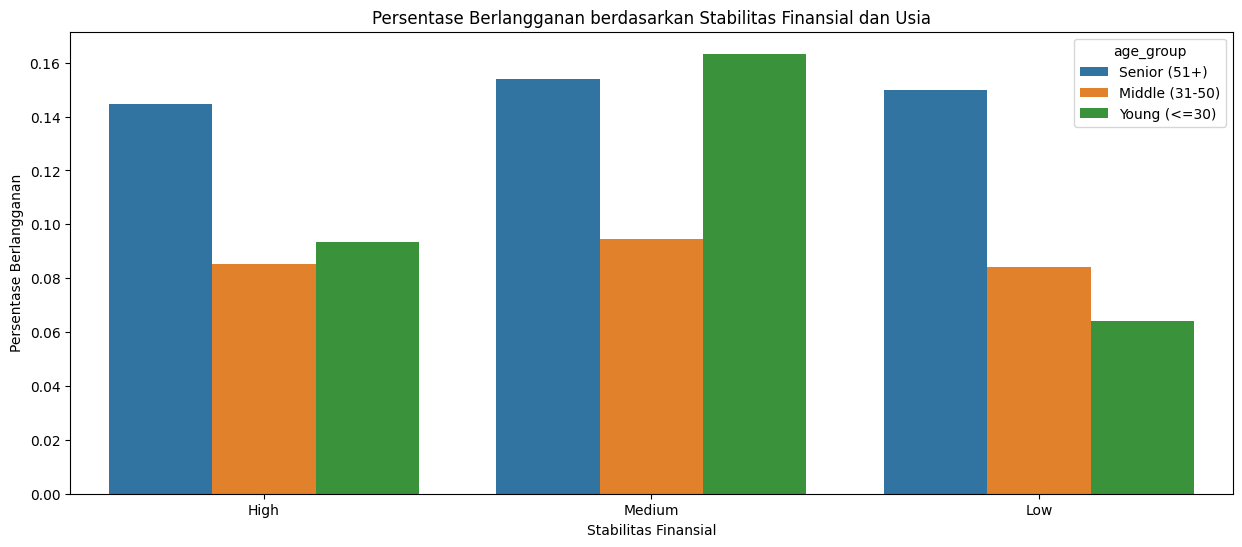

In [20]:
#ubah month agar berurutan
month_order = [
    'jan', 'feb', 'mar', 'apr', 'may', 'jun', 
    'jul', 'aug', 'sep', 'oct', 'nov', 'dec'
]

df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
plt.figure(figsize=(15, 6))
sns.barplot(x='financial_stability', y=df['y'].map({'yes': 1, 'no': 0}), data=df, estimator=lambda x: sum(x == 1) / len(x), hue='age_group', ci=None)
plt.title('Persentase Berlangganan berdasarkan Stabilitas Finansial dan Usia')
plt.xlabel('Stabilitas Finansial')
plt.ylabel('Persentase Berlangganan')
plt.show()

**Interpretasi**:

* **Stabilitas Finansial 'Medium':** Kelompok usia **Young (<=30)** memiliki persentase berlangganan tertinggi (sekitar 16%) saat stabilitas finansial mereka 'Medium'.
* **Stabilitas Finansial 'High':** Kelompok usia **Senior (51+)** memiliki persentase berlangganan tertinggi (sekitar 14.5%) di antara kelompok dengan stabilitas finansial 'High'.
* **Stabilitas Finansial 'Low':** Kelompok usia **Senior (51+)** juga memiliki persentase berlangganan tertinggi (sekitar 15%) di antara kelompok dengan stabilitas finansial 'Low'.
* **Kelompok 'Middle (31-50)':** Kelompok ini secara konsisten memiliki persentase berlangganan terendah di semua kategori stabilitas finansial (berkisar antara 8% - 9%).
* **Kelompok 'Young (<=30)':** Menunjukkan variasi yang signifikan: sangat tinggi pada stabilitas finansial 'Medium', dan yang terendah pada stabilitas finansial 'Low'.

**Kesimpulan:**
* **Kelompok Usia Senior (51+)** menunjukkan tingkat berlangganan yang relatif konsisten dan tinggi di berbagai tingkat stabilitas finansial.
* **Kelompok Usia Muda (<=30)** adalah yang paling mungkin berlangganan jika mereka memiliki stabilitas finansial 'Medium'.
* **Kelompok Usia Menengah (31-50)** adalah yang paling sedikit berlangganan, terlepas dari tingkat stabilitas finansial mereka.

### Stabilitas Kampa dan Poutcome

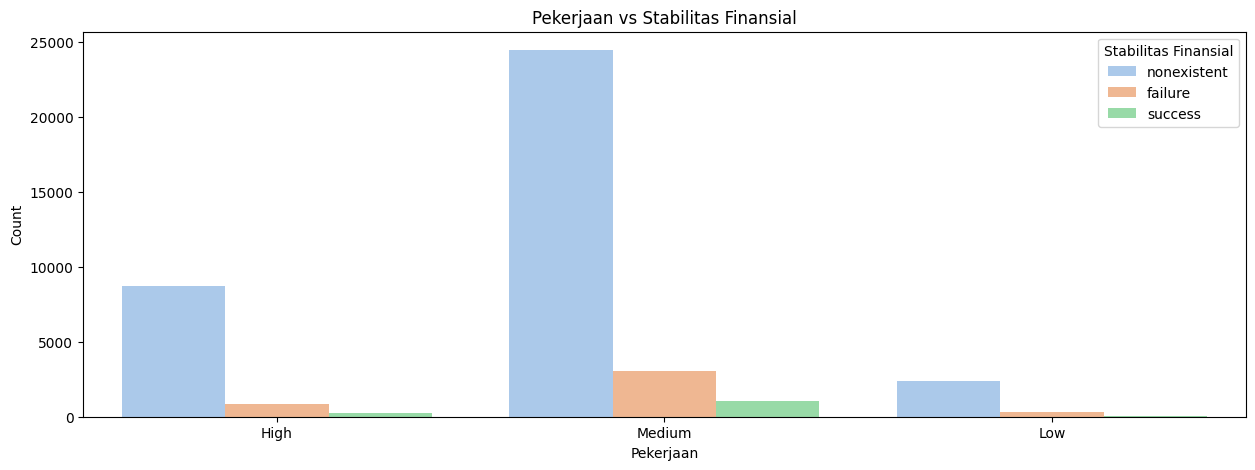

In [22]:
plt.figure(figsize=(15, 5))
sns.countplot(x='financial_stability', hue='poutcome', data=df, palette='pastel')
plt.title('Pekerjaan vs Stabilitas Finansial')
plt.xlabel('Pekerjaan')
plt.ylabel('Count')
plt.legend(title='Stabilitas Finansial')
plt.show()

**Interpretasi**:

* **Mayoritas Tidak Ada Hasil Kampanye/Campaign = Nonexistent:** Di semua tingkat stabilitas finansial (High, Medium, Low), jumlah terbesar adalah untuk kategori 'nonexistent' (batang biru muda), menunjukkan bahwa sebagian besar individu belum pernah dihubungi untuk kampanye pemasaran atau tidak ada hasil yang tercatat.
* **Stabilitas Finansial 'Medium' Paling Dominan:** Kategori 'Medium' memiliki jumlah individu terbesar secara keseluruhan, baik untuk 'nonexistent', 'failure', maupun 'success'.
    * Ada sekitar 24,000+ individu dengan stabilitas finansial 'Medium' yang hasilnya 'nonexistent'.
    * Sekitar 3,000+ individu dengan stabilitas finansial 'Medium' mengalami 'failure'.
    * Sekitar 1,000+ individu dengan stabilitas finansial 'Medium' mengalami 'success'.
* **Stabilitas Finansial 'High':**
    * Memiliki jumlah 'nonexistent' yang cukup tinggi (sekitar 9,000+).
    * Jumlah 'failure' dan 'success' jauh lebih kecil dibandingkan 'nonexistent' di kategori ini.
* **Stabilitas Finansial 'Low':**
    * Memiliki jumlah 'nonexistent' yang signifikan (sekitar 2,500+), namun lebih rendah dari 'High' dan 'Medium'.
    * Jumlah 'failure' dan 'success' sangat kecil di kategori ini.
* **Hasil 'Success' Terendah:** Di semua kategori stabilitas finansial, 'success' (batang hijau muda) memiliki jumlah yang paling rendah dibandingkan 'nonexistent' atau 'failure'.

**Kesimpulan:**
Sebagian besar individu belum memiliki riwayat kampanye ('nonexistent'). Individu dengan stabilitas finansial 'Medium' adalah kelompok terbesar di semua hasil kampanye (nonexistent, failure, success). Tingkat keberhasilan kampanye ('success') secara umum sangat rendah di semua tingkat stabilitas finansial.

In [21]:
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names")


### Kesimpulan Insight

**Potensi Terbesar Ada pada Usia Menengah dengan Pendidikan Tinggi**:

- Kelompok usia 31-50 tahun (Menengah) adalah demografi terbesar di dataset kita, baik di kalangan pelanggan maupun non-pelanggan.

- Mereka yang memiliki pendidikan Universitas (university.degree) dan Sekolah Menengah Atas (high.school) juga merupakan segmen pendidikan terbesar di kedua kelompok (berlangganan & tidak).

- Implikasi: Kampanye pemasaran massal kemungkinan akan paling efektif jika menargetkan kelompok usia menengah ini, khususnya dengan fokus pada latar belakang pendidikan tersebut. Namun, karena mereka juga mayoritas di non-pelanggan, kita perlu strategi yang lebih spesifik untuk mengonversi mereka.

**Stabilitas Finansial Menengah adalah Kunci, Terutama untuk Kaum Muda**:

- Sebagian besar individu dalam dataset kita memiliki stabilitas finansial 'Medium'.

- Menariknya, kaum muda (<=30 tahun) menunjukkan persentase berlangganan tertinggi (sekitar 16%) saat mereka memiliki stabilitas finansial 'Medium'.

- Implikasi: Ada peluang besar untuk menargetkan segmen usia muda dengan stabilitas finansial menengah. Pahami kebutuhan mereka dan tawarkan produk yang relevan untuk menarik mereka.

**Pelanggan Cenderung Berstatus Menikah dan Tidak Memiliki Pinjaman**:

- Individu yang menikah (married) dan tidak memiliki pinjaman (loan = no) adalah demografi yang dominan di antara pelanggan kita.

- Implikasi: Pertimbangkan untuk menyesuaikan pesan pemasaran agar sesuai dengan gaya hidup dan prioritas rumah tangga yang sudah menikah. Prioritaskan target yang tidak memiliki beban pinjaman personal, karena mereka cenderung lebih terbuka terhadap penawaran.

**Pekerjaan Administratif dan Blue-Collar Dominan**:

- Profesi seperti 'admin.', 'blue-collar', dan 'technician' adalah yang paling banyak populasinya dalam dataset, dan mayoritas dari mereka memiliki stabilitas finansial 'Medium'.

- Implikasi: Saluran dan pesan pemasaran harus mempertimbangkan karakteristik dan kebiasaan kelompok profesi ini.

**Tantangan Konversi dan Pentingnya Riwayat Kampanye**:

- Tingkat keberhasilan kampanye sebelumnya ('success') sangat rendah di semua tingkat stabilitas finansial. Mayoritas individu tidak memiliki riwayat kampanye ('nonexistent').

- Implikasi: Ini menunjukkan bahwa strategi kampanye sebelumnya mungkin belum optimal. Ada banyak "lapangan kosong" (nonexistent) yang bisa dieksplorasi. Kita perlu menguji pendekatan baru dan lebih personal untuk meningkatkan tingkat konversi, daripada hanya mengandalkan metode yang sama.

- Jangan terpaku pada kegagalan masa lalu. Ada potensi besar pada segmen pasar yang belum dijangkau, terutama kelompok usia menengah dengan pendidikan tinggi.

# Machine Learning

In [2]:
df_model = pd.read_csv('../Data/data-feature-engineering.csv')
pd.set_option('display.max_columns', None)
df_model

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_group,financial_stability,previous_success,campaign_frequency,economic_condition,econ_score,has_previous_contact,pdays_group,high_subscription_job
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Senior (51+),High,0,Low (<=2),Stable,0.749185,0,Never,0
1,57,services,married,high.school,no,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Senior (51+),High,0,Low (<=2),Stable,0.749185,0,Never,0
2,37,services,married,high.school,yes,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Middle (31-50),Medium,0,Low (<=2),Stable,0.749185,0,Never,0
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Middle (31-50),High,0,Low (<=2),Stable,0.749185,0,Never,0
4,56,services,married,high.school,no,yes,telephone,may,mon,1,999,not_contacted,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,Senior (51+),Medium,0,Low (<=2),Stable,0.749185,0,Never,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,69,retired,married,professional.course,yes,no,cellular,nov,fri,1,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,Senior (51+),Medium,0,Low (<=2),Unstable,-1.491102,0,Never,1
41172,46,blue-collar,married,professional.course,no,no,cellular,nov,fri,1,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,Middle (31-50),High,0,Low (<=2),Unstable,-1.491102,0,Never,0
41173,56,retired,married,university.degree,yes,no,cellular,nov,fri,2,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,Senior (51+),Medium,0,Low (<=2),Unstable,-1.491102,0,Never,1
41174,44,technician,married,professional.course,no,no,cellular,nov,fri,1,999,not_contacted,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,Middle (31-50),High,0,Low (<=2),Unstable,-1.491102,0,Never,0


## Data Preprocessing

### Drop columns tidak terpakai

In [3]:
df_model.drop(columns=['age', 'poutcome', 'pdays', 'campaign', 'emp.var.rate', 'euribor3m',
                       'cons.conf.idx', 'previous'], inplace=True)

## Mengubah nama target dan mengubah yes dan no menjadi 1 dan 0

In [4]:
df_model.rename(columns={'y': 'deposit'}, inplace=True)
df_model['deposit'] = np.where(df_model['deposit'] == 'yes',1,0)

In [5]:
df_model

,job,marital,education,housing,loan,contact,month,day_of_week,cons.price.idx,nr.employed,deposit,age_group,financial_stability,previous_success,campaign_frequency,economic_condition,econ_score,has_previous_contact,pdays_group,high_subscription_job
0,housemaid,married,basic.4y,no,no,telephone,may,mon,93.994,5191.0,0,Senior (51+),High,0,Low (<=2),Stable,0.749185,0,Never,0
1,services,married,high.school,no,no,telephone,may,mon,93.994,5191.0,0,Senior (51+),High,0,Low (<=2),Stable,0.749185,0,Never,0
2,services,married,high.school,yes,no,telephone,may,mon,93.994,5191.0,0,Middle (31-50),Medium,0,Low (<=2),Stable,0.749185,0,Never,0
3,admin.,married,basic.6y,no,no,telephone,may,mon,93.994,5191.0,0,Middle (31-50),High,0,Low (<=2),Stable,0.749185,0,Never,0
4,services,married,high.school,no,yes,telephone,may,mon,93.994,5191.0,0,Senior (51+),Medium,0,Low (<=2),Stable,0.749185,0,Never,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,retired,married,professional.course,yes,no,cellular,nov,fri,94.767,4963.6,1,Senior (51+),Medium,0,Low (<=2),Unstable,-1.491102,0,Never,1
41172,blue-collar,married,professional.course,no,no,cellular,nov,fri,94.767,4963.6,0,Middle (31-50),High,0,Low (<=2),Unstable,-1.491102,0,Never,0
41173,retired,married,university.degree,yes,no,cellular,nov,fri,94.767,4963.6,0,Senior (51+),Medium,0,Low (<=2),Unstable,-1.491102,0,Never,1
41174,technician,married,professional.course,no,no,cellular,nov,fri,94.767,4963.6,1,Middle (31-50),High,0,Low (<=2),Unstable,-1.491102,0,Never,0


In [6]:
# save df_model to csv
df_model.to_csv('../Data/model-w-feature.csv', index=False)

## Pipeline

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, PolynomialFeatures, PowerTransformer, StandardScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel

from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import grid_search_params as gsp
from jcopml.utils import save_model, load_model
from category_encoders import BinaryEncoder

**Defining Scaler**

The chosen scaler is Robust Scaler because it uses the median and IQR (Interquartile Range) for scaling, making it more robust when applied to datasets that contain many outliers or are not normally distributed (non-parametric).

In [8]:
def num_pipe(impute='median', poly=None, scaling=None, n_neighbors=5,
             max_iter=10, weights="uniform"):

  # pastikan parameter diatas diinput dengan benar
  if impute not in ['knn', 'mean', 'median', 'iterative', None]:
    raise Exception("impute only supports {'knn', 'mean', 'median', None}")
  if scaling not in ['standard', 'minmax', 'robust', 'maxabs', 'normalize', None]:
    raise Exception("scaling only supports {'standard', 'minmax', 'robust', 'maxabs', 'normalize'}")
  if (type(poly) is not int) and (poly is not None):
    raise Exception("poly should be int or None")

  # define imputer
  if impute is None:
    steps = []
  elif impute == "knn":
    steps = [('imputer', KNNImputer(n_neighbors=n_neighbors, weights=weights))]
  elif impute == "iterative":
    steps = [('imputer', IterativeImputer(max_iter=max_iter, random_state=0))]
  elif impute == "constant":
    steps = [('imputer', SimpleImputer(strategy=impute, fill_value="no_info"))]
  else:
    steps = [('imputer', SimpleImputer(strategy=impute))]

  # define poly jika digunakan
  if poly is not None:
    steps.append(('poly', PolynomialFeatures(poly)))

  # define scaling jika digunakan
  if scaling == 'standard':
    steps.append(('scaler', StandardScaler()))
  elif scaling == 'minmax':
    steps.append(('scaler', MinMaxScaler()))
  elif scaling == 'robust':
    steps.append(('scaler', RobustScaler()))

  return Pipeline(steps)

def cat_pipe(impute='most_frequent', encoder='onehot'):
  if impute not in ['most_frequent', 'constant', None]:
    raise Exception("impute only supports {'most_frequent', None}")
  if encoder not in ['onehot', 'ordinal', 'binary', None]:
    raise Exception("encoder should be boolean {'onehot', 'ordinal', 'binary', None}")

  if impute is None:
    steps = []
  else:
    steps = [('imputer', SimpleImputer(strategy=impute))]

  if encoder is not None:
    if encoder == 'onehot':
      steps.append(('onehot', OneHotEncoder(handle_unknown='ignore')))
    elif encoder == 'ordinal':
      steps.append(('ordinal', OrdinalEncoder()))
    elif encoder == 'binary':
      steps.append(('binary', BinaryEncoder()))

  return Pipeline(steps)

In [9]:
df_model.columns

Index(['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'cons.price.idx', 'nr.employed', 'deposit', 'age_group',
       'financial_stability', 'previous_success', 'campaign_frequency',
       'economic_condition', 'econ_score', 'has_previous_contact',
       'pdays_group', 'high_subscription_job'],
      dtype='object')

In [10]:
numeric_col = ['cons.price.idx', 'nr.employed']
ordinal_col = ['age_group', 'education', 'financial_stability']
one_hot_col = ['marital', 'housing', 'loan', 'contact', 'previous_success', 
               'campaign_frequency','economic_condition', 'econ_score', 
               'has_previous_contact', 'pdays_group', 'high_subscription_job']
binary_col = ['job', 'month', 'day_of_week']

# Pipeline kategorik untuk one-hot dan ordinal encoding
numeric_pipeline = num_pipe(scaling="robust")
ordinal_pipeline = cat_pipe(encoder="ordinal")
onehot_pipeline = cat_pipe(encoder="onehot")
binary_pipeline = cat_pipe(encoder='binary')

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_col),
    ('onehot_cat', onehot_pipeline, one_hot_col),
    ('ordinal_cat', ordinal_pipeline, ordinal_col),
    ('binary_col', binary_pipeline, binary_col)
])

## **Define Feature (X) and Target (y)**

In [11]:
# Splitting the independent variables from the target
# Features (X)
X = df_model.drop(columns='deposit')

# Target (y)
y = df_model['deposit']

## **Data Splitting**

In [12]:
# Splitting the data into training and test sets with an 80:20 ratio using stratified sampling

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,  
    test_size=0.2,
    stratify=y,
    random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (32940, 19)
y_train shape: (32940,)
X_test shape: (8236, 19)
y_test shape: (8236,)


## **Modelling**

## **Cross Validation**

In [13]:
# scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    VotingClassifier,
    StackingClassifier
)

# XGBoost & LightGBM
from xgboost import XGBClassifier
import lightgbm as lgb


In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score, fbeta_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  # <- Ubah ini
import numpy as np
import pandas as pd

# Model
xgb = XGBClassifier(random_state=42)

# Custom scorers
f1_scorer = make_scorer(f1_score)
f2_scorer = make_scorer(fbeta_score, beta=2)
f05_scorer = make_scorer(fbeta_score, beta=0.5)

# Dictionary of models
models = {'XGBoost': xgb}

# Cross-validation config
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

# Evaluate each model
for model_name, model in models.items():
    print(f'Model: {model_name} processing...')

    # Build pipeline
    pipeline = Pipeline(steps=[
        ('prep', preprocessor), 
        ('smote', SMOTE(random_state=42)),  # <- Ganti nama step & class
        ('model', model)
    ])

    # Cross-validation with all custom scorers
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring={
            'f0_5': f05_scorer,
            'f1': f1_scorer,
            'f2': f2_scorer,
            'recall': 'recall',
            'precision': 'precision'
        }
    )

    # Append results
    results.append({
        'Model': model_name,
        'Mean F0.5 Score': np.mean(scores['test_f0_5']),
        'Mean F1 Score': np.mean(scores['test_f1']),
        'Mean F2 Score': np.mean(scores['test_f2']),
        'Mean Recall': np.mean(scores['test_recall']),
        'Mean Precision': np.mean(scores['test_precision']),
        'Std F0.5 Score': np.std(scores['test_f0_5']),
        'Std F1 Score': np.std(scores['test_f1']),
        'Std F2 Score': np.std(scores['test_f2']),
        'Std Recall': np.std(scores['test_recall']),
        'Std Precision': np.std(scores['test_precision'])
    })

# Results DataFrame sorted by Precision
results_df_exp1_tf1 = pd.DataFrame(results)
results_df_exp1_tf1.sort_values(by='Mean Precision', ascending=False).reset_index(drop=True)

Model: XGBoost processing...


,Model,Mean F0.5 Score,Mean F1 Score,Mean F2 Score,Mean Recall,Mean Precision,Std F0.5 Score,Std F1 Score,Std F2 Score,Std Recall,Std Precision
0,XGBoost,0.49798,0.376983,0.303336,0.268393,0.633777,0.011548,0.007647,0.006685,0.006352,0.020637


## Memilih Model Terbaik
Terlihat Logistic Regression paling seimbang, maka kami memilih Logistic Regresion untuk model terbaik

In [16]:
transformer = Pipeline(steps=[
        ('prep', preprocessor), 
        ('smote', SMOTE(random_state=42)),
        ('model', xgb)
    ])

transformer.fit(
    X_train,
    y_train
)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['cons.price.idx',
                                                   'nr.employed']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['marital', 'housing', 'loan...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [18]:
# Predict
y_pred_xgb = transformer.predict(X_test)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_xgb))
print("F2 Score class 0:", fbeta_score(y_test, y_pred_xgb, beta=2, pos_label=0))
print("F2 Score class 1:", fbeta_score(y_test, y_pred_xgb, beta=2, pos_label=1))

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7308
           1       0.65      0.27      0.38       928

    accuracy                           0.90      8236
   macro avg       0.78      0.62      0.66      8236
weighted avg       0.88      0.90      0.88      8236

F2 Score class 0: 0.9672679231038852
F2 Score class 1: 0.30065998533365923


## tuning

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, fbeta_score, f1_score, precision_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom scorers (weighted for imbalance)
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
f1_scorer = make_scorer(f1_score, average='weighted')
f05_scorer = make_scorer(fbeta_score, beta=0.5, average='weighted')
precision_scorer = make_scorer(precision_score, average='weighted')

# Hyperparameter space untuk XGBoost
hyperparam_space = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 4, 5],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 1, 5]
}

# Pipeline with SMOTE
pipe_model = Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', xgb)
])

# RandomizedSearchCV
random_xgb = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=hyperparam_space,
    cv=skfold,
    scoring=f2_scorer,
    n_iter=50,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit model
random_xgb.fit(X_train, y_train)

# Output best params & score
print("Best Hyperparameters:")
print(random_xgb.best_params_)
print(f"Best F2 Score: {random_xgb.best_score_:.4f}")

# Evaluate best model
best_model = random_xgb.best_estimator_

scores = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=skfold,
    scoring={
        'f1': f1_scorer,
        'f2': f2_scorer,
        'f0_5': f05_scorer,
        'recall': 'recall',
        'precision': 'precision'
    }
)

# Summary
score_summary = {
    'F1 Score': np.mean(scores['test_f1']),
    'F2 Score': np.mean(scores['test_f2']),
    'F0.5 Score': np.mean(scores['test_f0_5']),
    'Recall': np.mean(scores['test_recall']),
    'Precision': np.mean(scores['test_precision']),
    'Std Precision': np.std(scores['test_precision'])
}

results = pd.DataFrame([score_summary])
print("\nCross-Validation Score Summary:")
print(results)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\MSI THIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:02:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters:
{'model__subsample': 0.8, 'model__n_estimators': 300, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__gamma': 5, 'model__colsample_bytree': 0.8}
Best F2 Score: 0.8915


c:\Users\MSI THIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:02:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSI THIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:02:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSI THIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:02:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MSI THIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:02:46] WARNI


Cross-Validation Score Summary:
   F1 Score  F2 Score  F0.5 Score    Recall  Precision  Std Precision
0  0.879874  0.890276    0.875965  0.255999   0.633085       0.032209
